### Importe de librerias 


In [1]:
#Para poner la barra de progreso durante el entrenamiento 
!pip install tqdm
import sys
!"{sys.executable}" -m pip install tqdm 

In [2]:
import pennylane as qml
import numpy as np
from pennylane import numpy as pnp
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import random
import pickle
from scipy.stats import truncnorm
import math

### Definición del dispositivo y número de qubits

Un dispositivo cuántico es un objeto que representa el backend donde se ejecuta el circuito cuántico.

qml.device carga un dispositivo cuántico particular.

'default.qubit':un simulador de estados puros.

'default.mixed':un simulador de estados mezclados.

In [3]:
#Definición del dispositivo cuántico
dev = qml.device("default.mixed", wires=4)

### Arquitectura del Circuito 


Un QNode es una función que contiene al circuito variacional y el dispositivo computacional en el que se ejecuta.

interface="autograd": le dice a PennyLane que los parámetros serán diferenciables con autograd (la librería automática de derivación).

qml.QubitDensityMatrix requiere el estado total del sistema completo.

Toma el estado base (qubits 0 y 1 en |00⟩⟨00|) y lo combina con el estado rho (en qubits 2 y 3) para formar el estado de los 4 qubits juntos.


In [4]:

@qml.qnode(dev) #Decorador para definir el circuito cuántico
def Circuit(params, rho):
    # Crear estado |00⟩⟨00| para qubits 0 y 1
    base = pnp.zeros((4,4), dtype=complex)
    base[0,0] = 1.0 # Para poner la primera entrada de la matriz en 1 y el resto en 0
    
    # Producto tensorial para obtener estado total de 4 qubits
    full_state = pnp.kron(base, rho)
    
    # Usar en el dispositivo de 4 qubits
    qml.QubitDensityMatrix(full_state, wires=[0, 1, 2, 3])
    
    qml.Rot(params[0], params[1], params[2], wires=0)
    qml.Rot(params[3], params[4], params[5], wires=1)
    qml.Rot(params[6], params[7], params[8], wires=2)
    qml.Rot(params[9], params[10], params[11], wires=3)
    
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[0, 2])
    qml.CNOT(wires=[0, 3])
    qml.CNOT(wires=[3, 0])

    # La compuerta v1 opera si el qubit de control (0) está en |1⟩


    qml.PauliX(wires=0)

    qml.ctrl(qml.Rot(params[12], params[13], params[14], wires=1), control=0)
    qml.ctrl(qml.Rot(params[15], params[16], params[17], wires=2), control=0)
    qml.ctrl(qml.Rot(params[18], params[19], params[20], wires=3), control=0)
        
    
    qml.ctrl(qml.CNOT(wires=[1, 2]), control=0)
    qml.ctrl(qml.CNOT(wires=[1, 3]), control=0)
    qml.ctrl(qml.CNOT(wires=[3, 1]), control=0)

    qml.PauliX(wires=0)

    # La compuerta v2 opera si el qubit de control (0) está en |0⟩


    qml.ctrl(qml.Rot(params[21], params[22], params[23], wires=1), control=0)
    qml.ctrl(qml.Rot(params[24], params[25], params[26], wires=2), control=0)
    qml.ctrl(qml.Rot(params[27], params[28], params[29], wires=3), control=0)
        
    
    qml.ctrl(qml.CNOT(wires=[1, 2]), control=0)
    qml.ctrl(qml.CNOT(wires=[1, 3]), control=0)
    qml.ctrl(qml.CNOT(wires=[3, 1]), control=0)    
    
    return qml.probs(wires=[0, 1]) 



### Definición de las familias 

dtype= complex porque aunque las matrices se definan para parametros a y b reales, 
la evolución del sistema si puede introducir números complejos.

In [5]:
def ρ1(a):
    
    psi1 = pnp.array([np.sqrt(1 - a*a), 0.0, a, 0.0], dtype=complex)
    rho1 = pnp.outer(psi1, psi1.conj())
    return rho1, 1

def ρ2(b):

    psi2 = pnp.array([0.0, np.sqrt(1 - b*b), b, 0.0], dtype=complex)
    psi3 = pnp.array([0.0, -np.sqrt(1 - b*b), b, 0.0], dtype=complex)
    rho2 = 0.5 * np.outer(psi2, psi2.conj()) + 0.5 * np.outer(psi3, psi3.conj())

    return rho2, 2
    

### Conjunto de Datos de Prueba 

Para el caso de la distribución uniforme

In [6]:
np.random.seed(2)
n_test = 10000
data_test = []

def sample_truncated_normal(mean, std, size):
    a, b = (0 - mean) / std, (1 - mean) / std
    return truncnorm(a, b, loc=mean, scale=std).rvs(size)

a_values = sample_truncated_normal(mean=0.25, std=0.05, size=n_test//3)

for a in a_values:
    rho, label = ρ1(a)
    data_test.append((rho, label))

b_test = np.random.uniform(0, 1, math.ceil(n_test*(2/3)))
for b in b_test:
    rho, label = ρ2(b)
    data_test.append((rho, label))

### Conjunto de Datos de Entrenamiento 


In [7]:
np.random.seed(90701)
n_samples = 600
data = []

def sample_truncated_normal(mean, std, size):
    a, b = (0 - mean) / std, (1 - mean) / std
    return truncnorm(a, b, loc=mean, scale=std).rvs(size)

a_values = sample_truncated_normal(mean=0.25, std=0.05, size=n_samples//3)
for a in a_values:
    rho, label = ρ1(a)
    data.append((rho, label))  


b_values = np.random.uniform(0, 1, math.ceil(n_samples*(2/3)))
for b in b_values:
    rho, label = ρ2(b)
    data.append((rho, label))

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)

### Función de Pérdida 


In [8]:
# Funciones de pérdida

# Clasificación mínimo error (Probabilidad de inconclusión casi nula)

alpha_err = 30  # penaliza los errores
alpha_inc = 2 # penaliza los resultados inconclusos


# Función de pérdida para una muestra según el label:
# label 1: familia 1 se espera que los outcomes 00 y 10 sean correctos.
# label 2: familia 2 se espera que el outcome 01 sea correcto.

def sample_loss(params, rho, label):
    
    probs = Circuit(params, rho)
    # |00> -> probs[0], |01> -> probs[1], |10> -> probs[2], |11> -> probs[3]
    if label == 1:
        # Familia 1 => éxito: (|00>, |10>), error: |01>, inconcluso: |11>
        p_suc = (probs[0] + probs[2])
        p_err = probs[1]
        p_inc = probs[3]
    else:
        # Familia 2 => éxito: |01>, error: (|00>, |10>), inconcluso: |11>
        p_suc = probs[1]
        p_err = probs[0] + probs[2]
        p_inc = probs[3]
        
    return (
    pnp.abs(p_suc - 1.0)
    + alpha_err * pnp.abs(p_err - 0.0)
    + alpha_inc * pnp.abs(p_inc - 0.0)
    )

# Función global de pérdida que promedia sobre el conjunto de muestras

def loss(params, samples):
    total = pnp.array(0.0, requires_grad=True) #iniciar el acumulador del costo total,
    #asegurar que ese acumulador soporta derivación automática, y permitir que luego PennyLane optimice los parámetros con gradientes.  

    for (rho, label) in samples:
        total = total + sample_loss(params, rho, label)

    avg = total / len(samples)           
    return avg  

In [9]:
def get_probabilities(params, rho, label):
    """Calcula las probabilidades de salida del circuito, dada la matriz de densidad."""
    
    return Circuit(params, rho)


### Evaluación del modelo

In [10]:
def evaluate_model(params, samples):
    """Evalúa tasas promedio de éxito, error e inconcluso en cada familia."""
    
    # Separar por familia
    S1 = [rho for (rho, label) in samples if label == 1]
    S2 = [rho for (rho, label) in samples if label == 2]

    total_suc_1, total_err_1, total_inc_1 = 0, 0, 0
    total_suc_2, total_err_2, total_inc_2 = 0, 0, 0

    for rho in S1:
        probs = get_probabilities(params, rho, 1)
        total_suc_1 += probs[0] + probs[2]  # éxito
        total_err_1 += probs[1]
        total_inc_1 += probs[3]

    for rho in S2:
        probs = get_probabilities(params, rho, 2)
        total_suc_2 += probs[1]             # éxito
        total_err_2 += probs[0] + probs[2]
        total_inc_2 += probs[3]

    # Promedios por familia
    n1, n2 = len(S1), len(S2)
    suc = (total_suc_1 + total_suc_2) / (n1 + n2)
    err = (total_err_1 + total_err_2) / (n1 + n2)
    inc = (total_inc_1 + total_inc_2) / (n1 + n2)

    return suc, err, inc


In [11]:
def get_batches(data, batch_size):
    # Asegurar que batch_size sea al menos 1
    batch_size = max(1, int(batch_size))
    
    # Mezclar los datos
    data_shuffled = random.sample(data, len(data))
    
    # Crear los lotes
    return [data_shuffled[i:i+batch_size] for i in range(0, len(data), batch_size)]


### Entrenamiento del modelo


params, curr_loss = opt.step_and_cost(lambda v: loss(v, data_train), params)

opt: Optimizador
.step_and_cost(...): Método que actualiza los parámetros y devuelve el valor de la función de costo


Calcula el valor de la función de la función de costo (loss(...)) para los parámetros actuales.
Calcula el gradiente de esa función de costo con respecto a los parámetros.
Actualiza los parámetros en la dirección que reduce la función de costo.

Devuelve:

params: los nuevos parámetros después de actualizar.

curr_loss: el valor actual de la función de costo.

La función lambda hace que el optimizador calcule la función de costo con los parámetros v usando el conjunto de datos data_train que ya está fijado.



In [12]:
opt = qml.AdamOptimizer(stepsize=0.01)
n_iter = 5000
batch_size = int(len(data_train) * 0.2)
val_batch_size = int(0.2 * batch_size)

initial_params = np.random.uniform(0, 2 * np.pi, 30)
params = pnp.array(initial_params, requires_grad=True)

# Early stopping
patience = 500
min_delta = 1e-4
best_val_loss = float('inf')
patience_counter = 0
best_params = params.copy()  # Guardar los mejores parámetros

# ReduceLROnPlateau
plateau_patience = 150
plateau_factor = 0.5
min_lr = 1e-5
plateau_counter = 0

# Historiales
loss_history = []
val_loss_history = []
train_suc_history = []
train_err_history = []
train_inc_history = []
val_suc_history = []
val_err_history = []
val_inc_history = []

for it in tqdm(range(n_iter), desc="Entrenando"):

    # Batch aleatorio
    batch = random.sample(data_train, batch_size)

    # Paso de entrenamiento
    params, train_loss = opt.step_and_cost(lambda v: loss(v, batch), params)

    # Evaluación en validación
    val_batches = get_batches(data_val, val_batch_size)
    val_loss = 0
    for vb in val_batches:
        val_loss += loss(params, vb) * len(vb)
    val_loss /= len(data_val)

    # EARLY STOPPING 
    if val_loss < best_val_loss - min_delta:  # Mejora significativa
        best_val_loss = val_loss
        best_params = params.copy()  # Guardar mejores parámetros
        patience_counter = 0
        plateau_counter = 0  # reinicia ambos contadores
    else:
        patience_counter += 1
        plateau_counter += 1

    # REDUCE LR ON PLATEAU 
    if plateau_counter >= plateau_patience:
        new_lr = max(opt.stepsize * plateau_factor, min_lr)
        if new_lr < opt.stepsize:
            print(f"Reducción de learning rate: {opt.stepsize:.5f} → {new_lr:.5f}")
            opt.stepsize = new_lr
            plateau_counter = 0  # Reiniciar después de reducir LR

    # STOPPING 
    if patience_counter >= patience:
        print(f"Early stopping en iteración {it+1}. Mejor pérdida de validación: {best_val_loss:.6f}")
        params = best_params  # Restaurar mejores parámetros
        break

    # Evaluación en train, test y validación
    suc_train, err_train, inc_train = evaluate_model(params, data_train)
    suc_val, err_val, inc_val = evaluate_model(params, data_val)


    # Guardar métricas
    loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    train_suc_history.append(suc_train)
    train_err_history.append(err_train)
    train_inc_history.append(inc_train)
    val_suc_history.append(suc_val)
    val_err_history.append(err_val)
    val_inc_history.append(inc_val)

    if (it + 1) % 50 == 0:
        print(f"Iter {it+1:3d}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, "
              f"train_suc={suc_train:.3f}, train_err={err_train:.3f}, train_inc={inc_train:.3f} | "
              f"val_suc={suc_val:.3f}, val_err={err_val:.3f}, val_inc={inc_val:.3f}") 
    if (it + 1) % 100 == 0:
        print(f"Iter {it+1}: LR actual = {opt.stepsize:.6f}")

# Usar los mejores parámetros al final
params = best_params

# Final
print("\nParámetros entrenados:")
print(params)

print("\nResultados finales en el conjunto de prueba:")
test_suc, test_err, test_inc = evaluate_model(params, data_test)
print(f"  Éxito promedio     = {test_suc:.4f}")
print(f"  Error promedio     = {test_err:.4f}")
print(f"  Inconcluso promedio = {test_inc:.4f}")




Entrenando:   0%|          | 0/5000 [00:00<?, ?it/s]

Entrenando:   0%|          | 1/5000 [00:58<81:41:03, 58.82s/it]

Entrenando:   0%|          | 2/5000 [02:02<85:54:01, 61.87s/it]

Entrenando:   0%|          | 3/5000 [03:09<88:53:55, 64.05s/it]

Entrenando:   0%|          | 4/5000 [04:17<91:04:56, 65.63s/it]

Entrenando:   0%|          | 5/5000 [05:23<91:27:25, 65.92s/it]

Entrenando:   0%|          | 6/5000 [06:26<89:43:47, 64.68s/it]

Entrenando:   0%|          | 7/5000 [07:28<88:46:44, 64.01s/it]

Entrenando:   0%|          | 8/5000 [08:33<88:56:54, 64.15s/it]

Entrenando:   0%|          | 9/5000 [09:33<87:00:51, 62.76s/it]

Entrenando:   0%|          | 10/5000 [10:29<84:30:27, 60.97s/it]

Entrenando:   0%|          | 11/5000 [11:23<81:11:34, 58.59s/it]

Entrenando:   0%|          | 12/5000 [12:31<85:23:54, 61.63s/it]

Entrenando:   0%|          | 13/5000 [13:57<95:17:52, 68.79s/it]

Entrenando:   0%|          | 14/5000 [15:45<112:03:56, 80.91s/it]

Entrenando:   0%|          | 15/5000 [17:28<120:56:43, 87.34s/it]

Entrenando:   0%|          | 16/5000 [19:07<125:45:03, 90.83s/it]

Entrenando:   0%|          | 17/5000 [20:47<129:29:37, 93.55s/it]

Entrenando:   0%|          | 18/5000 [22:34<135:11:52, 97.69s/it]

Entrenando:   0%|          | 19/5000 [24:17<137:31:09, 99.39s/it]

Entrenando:   0%|          | 20/5000 [26:07<141:39:50, 102.41s/it]

Entrenando:   0%|          | 21/5000 [27:47<140:58:26, 101.93s/it]

Entrenando:   0%|          | 22/5000 [29:29<140:40:33, 101.73s/it]

Entrenando:   0%|          | 23/5000 [31:10<140:15:42, 101.46s/it]

Entrenando:   0%|          | 24/5000 [32:49<139:20:25, 100.81s/it]

Entrenando:   0%|          | 25/5000 [34:31<139:56:58, 101.27s/it]

Entrenando:   1%|          | 26/5000 [36:43<152:43:02, 110.53s/it]

Entrenando:   1%|          | 27/5000 [39:01<163:58:38, 118.70s/it]

Entrenando:   1%|          | 28/5000 [41:19<171:52:21, 124.45s/it]

Entrenando:   1%|          | 29/5000 [43:37<177:38:20, 128.65s/it]

Entrenando:   1%|          | 30/5000 [45:59<183:06:55, 132.64s/it]

Entrenando:   1%|          | 31/5000 [48:34<192:15:46, 139.29s/it]

Entrenando:   1%|          | 32/5000 [50:56<193:14:41, 140.03s/it]

Entrenando:   1%|          | 33/5000 [53:22<195:38:10, 141.79s/it]

Entrenando:   1%|          | 34/5000 [55:41<194:28:51, 140.98s/it]

Entrenando:   1%|          | 35/5000 [58:07<196:21:28, 142.37s/it]

Entrenando:   1%|          | 36/5000 [1:00:30<196:36:23, 142.58s/it]

Entrenando:   1%|          | 37/5000 [1:03:01<200:19:03, 145.30s/it]

Entrenando:   1%|          | 38/5000 [1:05:22<198:31:04, 144.03s/it]

Entrenando:   1%|          | 39/5000 [1:07:40<195:41:41, 142.01s/it]

Entrenando:   1%|          | 40/5000 [1:09:55<192:44:05, 139.89s/it]

Entrenando:   1%|          | 41/5000 [1:12:11<191:08:01, 138.75s/it]

Entrenando:   1%|          | 42/5000 [1:14:27<189:55:23, 137.90s/it]

Entrenando:   1%|          | 43/5000 [1:16:42<189:02:40, 137.29s/it]

Entrenando:   1%|          | 44/5000 [1:18:58<188:09:11, 136.67s/it]

Entrenando:   1%|          | 45/5000 [1:21:11<186:45:07, 135.68s/it]

Entrenando:   1%|          | 46/5000 [1:23:27<186:38:34, 135.63s/it]

Entrenando:   1%|          | 47/5000 [1:25:34<183:14:10, 133.18s/it]

Entrenando:   1%|          | 48/5000 [1:27:44<181:57:07, 132.28s/it]

Entrenando:   1%|          | 49/5000 [1:29:51<179:44:53, 130.70s/it]

Entrenando:   1%|          | 50/5000 [1:31:47<173:44:48, 126.36s/it]

Iter  50: train_loss=6.8043, val_loss=6.7963, train_suc=0.356, train_err=0.178, train_inc=0.466 | val_suc=0.375, val_err=0.176, val_inc=0.450


Entrenando:   1%|          | 51/5000 [1:33:44<169:44:01, 123.47s/it]

Entrenando:   1%|          | 52/5000 [1:35:29<161:54:55, 117.80s/it]

Entrenando:   1%|          | 53/5000 [1:37:14<156:32:29, 113.92s/it]

Entrenando:   1%|          | 54/5000 [1:38:53<150:32:57, 109.58s/it]

Entrenando:   1%|          | 55/5000 [1:40:49<153:11:49, 111.53s/it]

Entrenando:   1%|          | 56/5000 [1:42:29<148:12:17, 107.92s/it]

Entrenando:   1%|          | 57/5000 [1:44:24<151:07:54, 110.07s/it]

Entrenando:   1%|          | 58/5000 [1:46:10<149:42:33, 109.06s/it]

Entrenando:   1%|          | 59/5000 [1:48:04<151:40:40, 110.51s/it]

Entrenando:   1%|          | 60/5000 [1:49:51<150:16:15, 109.51s/it]

Entrenando:   1%|          | 61/5000 [1:51:33<146:46:19, 106.98s/it]

Entrenando:   1%|          | 62/5000 [1:53:11<143:16:20, 104.45s/it]

Entrenando:   1%|▏         | 63/5000 [1:54:49<140:25:43, 102.40s/it]

Entrenando:   1%|▏         | 64/5000 [1:56:23<136:53:41, 99.84s/it] 

Entrenando:   1%|▏         | 65/5000 [1:57:55<133:56:23, 97.71s/it]

Entrenando:   1%|▏         | 66/5000 [1:59:34<134:27:06, 98.10s/it]

Entrenando:   1%|▏         | 67/5000 [2:01:09<132:53:40, 96.98s/it]

Entrenando:   1%|▏         | 68/5000 [2:02:48<133:50:23, 97.69s/it]

Entrenando:   1%|▏         | 69/5000 [2:04:23<132:30:07, 96.74s/it]

Entrenando:   1%|▏         | 70/5000 [2:05:57<131:22:28, 95.93s/it]

Entrenando:   1%|▏         | 71/5000 [2:07:35<132:29:35, 96.77s/it]

Entrenando:   1%|▏         | 72/5000 [2:09:10<131:28:18, 96.04s/it]

Entrenando:   1%|▏         | 73/5000 [2:10:45<131:07:10, 95.80s/it]

Entrenando:   1%|▏         | 74/5000 [2:12:17<129:35:14, 94.70s/it]

Entrenando:   2%|▏         | 75/5000 [2:13:49<128:28:02, 93.91s/it]

Entrenando:   2%|▏         | 76/5000 [2:15:21<127:38:56, 93.33s/it]

Entrenando:   2%|▏         | 77/5000 [2:16:52<126:37:15, 92.59s/it]

Entrenando:   2%|▏         | 78/5000 [2:18:17<123:19:54, 90.21s/it]

Entrenando:   2%|▏         | 79/5000 [2:19:41<120:53:01, 88.43s/it]

Entrenando:   2%|▏         | 80/5000 [2:21:06<119:18:02, 87.29s/it]

Entrenando:   2%|▏         | 81/5000 [2:22:28<117:22:05, 85.90s/it]

Entrenando:   2%|▏         | 82/5000 [2:23:52<116:18:26, 85.14s/it]

Entrenando:   2%|▏         | 83/5000 [2:25:16<116:04:32, 84.99s/it]

Entrenando:   2%|▏         | 84/5000 [2:26:35<113:44:08, 83.29s/it]

Entrenando:   2%|▏         | 85/5000 [2:27:53<111:21:45, 81.57s/it]

Entrenando:   2%|▏         | 86/5000 [2:29:08<108:47:47, 79.70s/it]

Entrenando:   2%|▏         | 87/5000 [2:30:23<106:52:17, 78.31s/it]

Entrenando:   2%|▏         | 88/5000 [2:31:33<103:14:37, 75.67s/it]

Entrenando:   2%|▏         | 89/5000 [2:32:45<101:55:09, 74.71s/it]

Entrenando:   2%|▏         | 90/5000 [2:34:03<103:01:39, 75.54s/it]

Entrenando:   2%|▏         | 91/5000 [2:35:15<101:27:11, 74.40s/it]

Entrenando:   2%|▏         | 92/5000 [2:36:26<100:17:16, 73.56s/it]

Entrenando:   2%|▏         | 93/5000 [2:37:41<100:34:39, 73.79s/it]

Entrenando:   2%|▏         | 94/5000 [2:38:50<98:41:06, 72.41s/it] 

Entrenando:   2%|▏         | 95/5000 [2:40:03<99:04:33, 72.72s/it]

Entrenando:   2%|▏         | 96/5000 [2:41:15<98:35:26, 72.37s/it]

Entrenando:   2%|▏         | 97/5000 [2:42:20<95:39:34, 70.24s/it]

Entrenando:   2%|▏         | 98/5000 [2:43:26<93:50:32, 68.92s/it]

Entrenando:   2%|▏         | 99/5000 [2:44:36<94:21:48, 69.31s/it]

Entrenando:   2%|▏         | 100/5000 [2:45:46<94:38:33, 69.53s/it]

Iter 100: train_loss=2.6561, val_loss=2.6522, train_suc=0.417, train_err=0.034, train_inc=0.550 | val_suc=0.436, val_err=0.034, val_inc=0.530
Iter 100: LR actual = 0.010000


Entrenando:   2%|▏         | 101/5000 [2:46:54<94:06:56, 69.16s/it]

Entrenando:   2%|▏         | 102/5000 [2:48:01<92:55:51, 68.30s/it]

Entrenando:   2%|▏         | 103/5000 [2:49:11<93:32:15, 68.76s/it]

Entrenando:   2%|▏         | 104/5000 [2:50:22<94:24:48, 69.42s/it]

Entrenando:   2%|▏         | 105/5000 [2:51:33<95:23:55, 70.16s/it]

Entrenando:   2%|▏         | 106/5000 [2:52:38<93:07:55, 68.51s/it]

Entrenando:   2%|▏         | 107/5000 [2:53:42<91:11:27, 67.09s/it]

Entrenando:   2%|▏         | 108/5000 [2:54:56<93:50:58, 69.06s/it]

Entrenando:   2%|▏         | 109/5000 [2:56:12<96:46:49, 71.23s/it]

Entrenando:   2%|▏         | 110/5000 [2:57:28<98:41:09, 72.65s/it]

Entrenando:   2%|▏         | 111/5000 [2:58:34<95:54:42, 70.62s/it]

Entrenando:   2%|▏         | 112/5000 [2:59:43<95:26:14, 70.29s/it]

Entrenando:   2%|▏         | 113/5000 [3:00:57<96:45:16, 71.27s/it]

Entrenando:   2%|▏         | 114/5000 [3:02:09<97:01:41, 71.49s/it]

Entrenando:   2%|▏         | 115/5000 [3:03:18<95:55:38, 70.69s/it]

Entrenando:   2%|▏         | 116/5000 [3:04:36<99:06:12, 73.05s/it]

Entrenando:   2%|▏         | 117/5000 [3:05:42<96:12:33, 70.93s/it]

Entrenando:   2%|▏         | 118/5000 [3:06:57<97:44:14, 72.07s/it]

Entrenando:   2%|▏         | 119/5000 [3:08:05<95:59:30, 70.80s/it]

Entrenando:   2%|▏         | 120/5000 [3:09:10<93:55:37, 69.29s/it]

Entrenando:   2%|▏         | 121/5000 [3:10:19<93:29:30, 68.98s/it]

Entrenando:   2%|▏         | 122/5000 [3:11:24<91:53:27, 67.82s/it]

Entrenando:   2%|▏         | 123/5000 [3:12:27<89:53:57, 66.36s/it]

Entrenando:   2%|▏         | 124/5000 [3:13:41<93:05:56, 68.74s/it]

Entrenando:   2%|▎         | 125/5000 [3:14:53<94:12:24, 69.57s/it]

Entrenando:   3%|▎         | 126/5000 [3:15:54<90:52:11, 67.12s/it]

Entrenando:   3%|▎         | 127/5000 [3:17:02<91:19:00, 67.46s/it]

Entrenando:   3%|▎         | 128/5000 [3:18:16<93:41:41, 69.23s/it]

Entrenando:   3%|▎         | 129/5000 [3:19:26<94:16:24, 69.67s/it]

Entrenando:   3%|▎         | 130/5000 [3:20:35<93:56:59, 69.45s/it]

Entrenando:   3%|▎         | 131/5000 [3:21:42<92:52:41, 68.67s/it]

Entrenando:   3%|▎         | 132/5000 [3:22:44<90:00:52, 66.57s/it]

Entrenando:   3%|▎         | 133/5000 [3:23:53<91:05:25, 67.38s/it]

Entrenando:   3%|▎         | 134/5000 [3:24:56<89:07:20, 65.94s/it]

Entrenando:   3%|▎         | 135/5000 [3:26:08<91:44:14, 67.88s/it]

Entrenando:   3%|▎         | 136/5000 [3:27:18<92:43:33, 68.63s/it]

Entrenando:   3%|▎         | 137/5000 [3:28:24<91:18:55, 67.60s/it]

Entrenando:   3%|▎         | 138/5000 [3:29:36<93:22:07, 69.13s/it]

Entrenando:   3%|▎         | 139/5000 [3:30:52<95:51:34, 70.99s/it]

Entrenando:   3%|▎         | 140/5000 [3:32:04<96:25:50, 71.43s/it]

Entrenando:   3%|▎         | 141/5000 [3:33:12<94:50:40, 70.27s/it]

Entrenando:   3%|▎         | 142/5000 [3:34:19<93:38:16, 69.39s/it]

Entrenando:   3%|▎         | 143/5000 [3:35:25<92:26:27, 68.52s/it]

Entrenando:   3%|▎         | 144/5000 [3:36:29<90:31:33, 67.11s/it]

Entrenando:   3%|▎         | 145/5000 [3:37:36<90:27:35, 67.08s/it]

Entrenando:   3%|▎         | 146/5000 [3:38:51<93:27:16, 69.31s/it]

Entrenando:   3%|▎         | 147/5000 [3:39:57<92:12:45, 68.40s/it]

Entrenando:   3%|▎         | 148/5000 [3:41:01<90:10:34, 66.91s/it]

Entrenando:   3%|▎         | 149/5000 [3:42:04<88:57:29, 66.02s/it]

Entrenando:   3%|▎         | 150/5000 [3:43:13<89:59:13, 66.79s/it]

Iter 150: train_loss=1.7570, val_loss=1.7144, train_suc=0.444, train_err=0.004, train_inc=0.552 | val_suc=0.464, val_err=0.004, val_inc=0.532


Entrenando:   3%|▎         | 151/5000 [3:44:25<92:10:08, 68.43s/it]

Entrenando:   3%|▎         | 152/5000 [3:45:35<92:48:08, 68.91s/it]

Entrenando:   3%|▎         | 153/5000 [3:46:45<93:10:05, 69.20s/it]

Entrenando:   3%|▎         | 154/5000 [3:48:02<96:18:13, 71.54s/it]

Entrenando:   3%|▎         | 155/5000 [3:49:12<95:40:17, 71.09s/it]

Entrenando:   3%|▎         | 156/5000 [3:50:27<97:12:01, 72.24s/it]

Entrenando:   3%|▎         | 157/5000 [3:51:34<95:01:28, 70.64s/it]

Entrenando:   3%|▎         | 158/5000 [3:52:46<95:23:06, 70.92s/it]

Entrenando:   3%|▎         | 159/5000 [3:53:46<91:17:55, 67.89s/it]

Entrenando:   3%|▎         | 160/5000 [3:55:02<94:30:10, 70.29s/it]

Entrenando:   3%|▎         | 161/5000 [3:56:10<93:33:03, 69.60s/it]

Entrenando:   3%|▎         | 162/5000 [3:57:21<94:08:16, 70.05s/it]

Entrenando:   3%|▎         | 163/5000 [3:58:28<92:49:06, 69.08s/it]

Entrenando:   3%|▎         | 164/5000 [3:59:40<94:02:30, 70.01s/it]

Entrenando:   3%|▎         | 165/5000 [4:00:50<93:55:16, 69.93s/it]

Entrenando:   3%|▎         | 166/5000 [4:01:54<91:31:02, 68.16s/it]

Entrenando:   3%|▎         | 167/5000 [4:03:12<95:15:49, 70.96s/it]

Entrenando:   3%|▎         | 168/5000 [4:04:24<95:40:41, 71.28s/it]

Entrenando:   3%|▎         | 169/5000 [4:05:38<96:59:46, 72.28s/it]

Entrenando:   3%|▎         | 170/5000 [4:06:51<97:19:15, 72.54s/it]

Entrenando:   3%|▎         | 171/5000 [4:08:06<98:02:04, 73.08s/it]

Entrenando:   3%|▎         | 172/5000 [4:09:16<96:44:12, 72.13s/it]

Entrenando:   3%|▎         | 173/5000 [4:10:27<96:27:11, 71.94s/it]

Entrenando:   3%|▎         | 174/5000 [4:11:41<97:11:11, 72.50s/it]

Entrenando:   4%|▎         | 175/5000 [4:12:49<95:13:23, 71.05s/it]

Entrenando:   4%|▎         | 176/5000 [4:13:57<94:06:12, 70.23s/it]

Entrenando:   4%|▎         | 177/5000 [4:15:03<92:15:53, 68.87s/it]

Entrenando:   4%|▎         | 178/5000 [4:16:13<92:40:20, 69.19s/it]

Entrenando:   4%|▎         | 179/5000 [4:17:28<95:00:25, 70.94s/it]

Entrenando:   4%|▎         | 180/5000 [4:18:34<93:17:13, 69.68s/it]

Entrenando:   4%|▎         | 181/5000 [4:19:37<90:19:32, 67.48s/it]

Entrenando:   4%|▎         | 182/5000 [4:20:46<91:07:05, 68.08s/it]

Entrenando:   4%|▎         | 183/5000 [4:21:52<89:59:17, 67.25s/it]

Entrenando:   4%|▎         | 184/5000 [4:23:01<90:55:27, 67.97s/it]

Entrenando:   4%|▎         | 185/5000 [4:24:23<96:33:37, 72.19s/it]

Entrenando:   4%|▎         | 186/5000 [4:25:34<95:59:20, 71.78s/it]

Entrenando:   4%|▎         | 187/5000 [4:26:50<97:45:24, 73.12s/it]

Entrenando:   4%|▍         | 188/5000 [4:28:02<97:00:51, 72.58s/it]

Entrenando:   4%|▍         | 189/5000 [4:29:09<94:57:54, 71.06s/it]

Entrenando:   4%|▍         | 190/5000 [4:30:13<92:13:22, 69.02s/it]

Entrenando:   4%|▍         | 191/5000 [4:31:19<90:38:41, 67.86s/it]

Entrenando:   4%|▍         | 192/5000 [4:32:38<95:06:00, 71.21s/it]

Entrenando:   4%|▍         | 193/5000 [4:33:49<95:01:47, 71.17s/it]

Entrenando:   4%|▍         | 194/5000 [4:35:05<97:10:53, 72.80s/it]

Entrenando:   4%|▍         | 195/5000 [4:36:17<96:33:42, 72.35s/it]

Entrenando:   4%|▍         | 196/5000 [4:37:23<93:59:33, 70.44s/it]

Entrenando:   4%|▍         | 197/5000 [4:38:35<94:35:37, 70.90s/it]

Entrenando:   4%|▍         | 198/5000 [4:39:42<93:10:44, 69.86s/it]

Entrenando:   4%|▍         | 199/5000 [4:40:47<91:19:12, 68.48s/it]

Entrenando:   4%|▍         | 200/5000 [4:41:52<89:54:51, 67.44s/it]

Iter 200: train_loss=1.7903, val_loss=1.6061, train_suc=0.451, train_err=0.001, train_inc=0.549 | val_suc=0.471, val_err=0.001, val_inc=0.528
Iter 200: LR actual = 0.010000


Entrenando:   4%|▍         | 201/5000 [4:43:10<93:56:39, 70.47s/it]

Entrenando:   4%|▍         | 202/5000 [4:44:24<95:15:32, 71.47s/it]

Entrenando:   4%|▍         | 203/5000 [4:45:39<96:54:11, 72.72s/it]

Entrenando:   4%|▍         | 204/5000 [4:46:51<96:26:23, 72.39s/it]

Entrenando:   4%|▍         | 205/5000 [4:47:48<90:32:00, 67.97s/it]

Entrenando:   4%|▍         | 206/5000 [4:48:58<90:57:14, 68.30s/it]

Entrenando:   4%|▍         | 207/5000 [4:50:01<89:08:15, 66.95s/it]

Entrenando:   4%|▍         | 208/5000 [4:51:03<86:56:52, 65.32s/it]

Entrenando:   4%|▍         | 209/5000 [4:52:24<93:09:47, 70.00s/it]

Entrenando:   4%|▍         | 210/5000 [4:54:02<104:20:00, 78.41s/it]

Entrenando:   4%|▍         | 211/5000 [4:56:14<125:52:43, 94.63s/it]

Entrenando:   4%|▍         | 212/5000 [4:58:14<135:43:44, 102.05s/it]

Entrenando:   4%|▍         | 213/5000 [5:00:14<142:56:47, 107.50s/it]

Entrenando:   4%|▍         | 214/5000 [5:02:11<146:37:54, 110.30s/it]

Entrenando:   4%|▍         | 215/5000 [5:04:15<152:00:32, 114.36s/it]

Entrenando:   4%|▍         | 216/5000 [5:06:17<155:02:15, 116.67s/it]

Entrenando:   4%|▍         | 217/5000 [5:08:14<155:19:57, 116.91s/it]

Entrenando:   4%|▍         | 218/5000 [5:10:11<155:18:40, 116.92s/it]

Entrenando:   4%|▍         | 219/5000 [5:12:13<157:26:34, 118.55s/it]

Entrenando:   4%|▍         | 220/5000 [5:14:11<156:58:14, 118.22s/it]

Entrenando:   4%|▍         | 221/5000 [5:16:16<159:35:06, 120.21s/it]

Entrenando:   4%|▍         | 222/5000 [5:18:25<163:03:04, 122.85s/it]

Entrenando:   4%|▍         | 223/5000 [5:20:34<165:31:44, 124.74s/it]

Entrenando:   4%|▍         | 224/5000 [5:22:42<166:57:15, 125.84s/it]

Entrenando:   4%|▍         | 225/5000 [5:24:51<168:15:30, 126.85s/it]

Entrenando:   5%|▍         | 226/5000 [5:27:03<170:02:42, 128.23s/it]

Entrenando:   5%|▍         | 227/5000 [5:29:11<169:48:10, 128.07s/it]

Entrenando:   5%|▍         | 228/5000 [5:31:17<169:09:07, 127.61s/it]

Entrenando:   5%|▍         | 229/5000 [5:33:24<168:56:00, 127.47s/it]

Entrenando:   5%|▍         | 230/5000 [5:35:33<169:12:37, 127.71s/it]

Entrenando:   5%|▍         | 231/5000 [5:37:41<169:22:38, 127.86s/it]

Entrenando:   5%|▍         | 232/5000 [5:39:50<169:45:23, 128.17s/it]

Entrenando:   5%|▍         | 233/5000 [5:41:57<169:15:44, 127.83s/it]

Entrenando:   5%|▍         | 234/5000 [5:44:06<169:52:33, 128.32s/it]

Entrenando:   5%|▍         | 235/5000 [5:46:13<169:16:08, 127.88s/it]

Entrenando:   5%|▍         | 236/5000 [5:48:20<168:51:04, 127.60s/it]

Entrenando:   5%|▍         | 237/5000 [5:50:29<169:29:38, 128.11s/it]

Entrenando:   5%|▍         | 238/5000 [5:52:36<169:04:47, 127.82s/it]

Entrenando:   5%|▍         | 239/5000 [5:54:45<169:31:24, 128.18s/it]

Entrenando:   5%|▍         | 240/5000 [5:56:57<170:55:02, 129.27s/it]

Entrenando:   5%|▍         | 241/5000 [5:59:10<172:26:27, 130.44s/it]

Entrenando:   5%|▍         | 242/5000 [6:01:18<171:17:42, 129.61s/it]

Entrenando:   5%|▍         | 243/5000 [6:03:27<170:48:17, 129.26s/it]

Entrenando:   5%|▍         | 244/5000 [6:05:34<169:57:35, 128.65s/it]

Entrenando:   5%|▍         | 245/5000 [6:07:30<165:11:58, 125.07s/it]

Entrenando:   5%|▍         | 246/5000 [6:09:21<159:13:14, 120.57s/it]

Entrenando:   5%|▍         | 247/5000 [6:11:17<157:44:17, 119.47s/it]

Entrenando:   5%|▍         | 248/5000 [6:13:03<152:15:00, 115.34s/it]

Entrenando:   5%|▍         | 249/5000 [6:14:44<146:17:40, 110.85s/it]

Entrenando:   5%|▌         | 250/5000 [6:16:25<142:39:56, 108.13s/it]

Iter 250: train_loss=1.6745, val_loss=1.5803, train_suc=0.455, train_err=0.000, train_inc=0.544 | val_suc=0.476, val_err=0.000, val_inc=0.523


Entrenando:   5%|▌         | 251/5000 [6:18:20<145:24:41, 110.23s/it]

Entrenando:   5%|▌         | 252/5000 [6:20:08<144:09:14, 109.30s/it]

Entrenando:   5%|▌         | 253/5000 [6:21:52<142:20:46, 107.95s/it]

Entrenando:   5%|▌         | 254/5000 [6:23:37<140:57:59, 106.93s/it]

Entrenando:   5%|▌         | 255/5000 [6:25:24<140:51:47, 106.87s/it]

Entrenando:   5%|▌         | 256/5000 [6:27:09<140:17:00, 106.45s/it]

Entrenando:   5%|▌         | 257/5000 [6:28:47<136:59:31, 103.98s/it]

Entrenando:   5%|▌         | 258/5000 [6:30:25<134:33:24, 102.15s/it]

Entrenando:   5%|▌         | 259/5000 [6:32:04<133:09:57, 101.12s/it]

Entrenando:   5%|▌         | 260/5000 [6:33:38<130:29:26, 99.11s/it] 

Entrenando:   5%|▌         | 261/5000 [6:35:09<127:14:05, 96.65s/it]

Entrenando:   5%|▌         | 262/5000 [6:36:33<122:08:37, 92.81s/it]

Entrenando:   5%|▌         | 263/5000 [6:37:57<118:28:55, 90.04s/it]

Entrenando:   5%|▌         | 264/5000 [6:39:21<116:05:45, 88.25s/it]

Entrenando:   5%|▌         | 265/5000 [6:40:46<114:43:38, 87.23s/it]

Entrenando:   5%|▌         | 266/5000 [6:42:09<113:05:59, 86.01s/it]

Entrenando:   5%|▌         | 267/5000 [6:43:32<111:54:47, 85.12s/it]

Entrenando:   5%|▌         | 268/5000 [6:44:56<111:23:16, 84.74s/it]

Entrenando:   5%|▌         | 269/5000 [6:46:21<111:38:25, 84.95s/it]

Entrenando:   5%|▌         | 270/5000 [6:47:43<110:15:14, 83.91s/it]

Entrenando:   5%|▌         | 271/5000 [6:48:58<106:44:01, 81.25s/it]

Entrenando:   5%|▌         | 272/5000 [6:50:15<105:11:36, 80.10s/it]

Entrenando:   5%|▌         | 273/5000 [6:51:35<105:03:23, 80.01s/it]

Entrenando:   5%|▌         | 274/5000 [6:52:51<103:36:29, 78.92s/it]

Entrenando:   6%|▌         | 275/5000 [6:54:06<102:03:38, 77.76s/it]

Entrenando:   6%|▌         | 276/5000 [6:55:25<102:31:59, 78.14s/it]

Entrenando:   6%|▌         | 277/5000 [6:56:41<101:41:20, 77.51s/it]

Entrenando:   6%|▌         | 278/5000 [6:57:59<101:50:10, 77.64s/it]

Entrenando:   6%|▌         | 279/5000 [6:59:16<101:27:36, 77.37s/it]

Entrenando:   6%|▌         | 280/5000 [7:00:29<99:31:06, 75.90s/it] 

Entrenando:   6%|▌         | 281/5000 [7:01:43<98:48:34, 75.38s/it]

Entrenando:   6%|▌         | 282/5000 [7:02:48<94:51:42, 72.38s/it]

Entrenando:   6%|▌         | 283/5000 [7:03:58<94:02:15, 71.77s/it]

Entrenando:   6%|▌         | 284/5000 [7:05:12<94:43:39, 72.31s/it]

Entrenando:   6%|▌         | 285/5000 [7:06:29<96:31:25, 73.70s/it]

Entrenando:   6%|▌         | 286/5000 [7:07:47<98:09:45, 74.97s/it]

Entrenando:   6%|▌         | 287/5000 [7:09:05<99:15:19, 75.82s/it]

Entrenando:   6%|▌         | 288/5000 [7:10:19<98:47:13, 75.47s/it]

Entrenando:   6%|▌         | 289/5000 [7:11:36<99:19:47, 75.90s/it]

Entrenando:   6%|▌         | 290/5000 [7:12:53<99:41:35, 76.20s/it]

Entrenando:   6%|▌         | 291/5000 [7:14:09<99:42:27, 76.23s/it]

Entrenando:   6%|▌         | 292/5000 [7:15:22<98:21:25, 75.21s/it]

Entrenando:   6%|▌         | 293/5000 [7:16:36<97:40:22, 74.70s/it]

Entrenando:   6%|▌         | 294/5000 [7:17:50<97:26:04, 74.54s/it]

Entrenando:   6%|▌         | 295/5000 [7:19:06<97:51:56, 74.88s/it]

Entrenando:   6%|▌         | 296/5000 [7:20:23<98:57:13, 75.73s/it]

Entrenando:   6%|▌         | 297/5000 [7:21:41<99:47:13, 76.38s/it]

Entrenando:   6%|▌         | 298/5000 [7:22:58<99:56:02, 76.51s/it]

Entrenando:   6%|▌         | 299/5000 [7:24:14<99:31:22, 76.21s/it]

Entrenando:   6%|▌         | 300/5000 [7:25:31<100:01:59, 76.62s/it]

Iter 300: train_loss=1.6512, val_loss=1.5405, train_suc=0.468, train_err=0.000, train_inc=0.532 | val_suc=0.490, val_err=0.000, val_inc=0.510
Iter 300: LR actual = 0.010000


Entrenando:   6%|▌         | 301/5000 [7:26:51<101:08:51, 77.49s/it]

Entrenando:   6%|▌         | 302/5000 [7:28:09<101:25:55, 77.73s/it]

Entrenando:   6%|▌         | 303/5000 [7:29:19<98:17:43, 75.34s/it] 

Entrenando:   6%|▌         | 304/5000 [7:30:27<95:41:37, 73.36s/it]

Entrenando:   6%|▌         | 305/5000 [7:31:30<91:34:35, 70.22s/it]

Entrenando:   6%|▌         | 306/5000 [7:32:37<90:02:11, 69.05s/it]

Entrenando:   6%|▌         | 307/5000 [7:33:38<87:05:06, 66.80s/it]

Entrenando:   6%|▌         | 308/5000 [7:34:44<86:39:52, 66.49s/it]

Entrenando:   6%|▌         | 309/5000 [7:35:59<90:05:46, 69.14s/it]

Entrenando:   6%|▌         | 310/5000 [7:37:04<88:10:13, 67.68s/it]

Entrenando:   6%|▌         | 311/5000 [7:38:04<85:28:54, 65.63s/it]

Entrenando:   6%|▌         | 312/5000 [7:39:11<85:40:17, 65.79s/it]

Entrenando:   6%|▋         | 313/5000 [7:40:21<87:32:28, 67.24s/it]

Entrenando:   6%|▋         | 314/5000 [7:41:32<89:03:00, 68.41s/it]

Entrenando:   6%|▋         | 315/5000 [7:42:35<86:40:34, 66.60s/it]

Entrenando:   6%|▋         | 316/5000 [7:43:41<86:31:50, 66.51s/it]

Entrenando:   6%|▋         | 317/5000 [7:44:47<86:26:47, 66.45s/it]

Entrenando:   6%|▋         | 318/5000 [7:45:55<86:51:49, 66.79s/it]

Entrenando:   6%|▋         | 319/5000 [7:47:06<88:24:11, 67.99s/it]

Entrenando:   6%|▋         | 320/5000 [7:48:23<91:54:48, 70.70s/it]

Entrenando:   6%|▋         | 321/5000 [7:49:29<90:12:06, 69.40s/it]

Entrenando:   6%|▋         | 322/5000 [7:50:43<91:58:56, 70.79s/it]

Entrenando:   6%|▋         | 323/5000 [7:51:56<92:48:36, 71.44s/it]

Entrenando:   6%|▋         | 324/5000 [7:53:00<89:45:58, 69.11s/it]

Entrenando:   6%|▋         | 325/5000 [7:54:08<89:16:38, 68.75s/it]

Entrenando:   7%|▋         | 326/5000 [7:55:17<89:36:26, 69.02s/it]

Entrenando:   7%|▋         | 327/5000 [7:56:33<92:06:33, 70.96s/it]

Entrenando:   7%|▋         | 328/5000 [7:57:38<90:02:33, 69.38s/it]

Entrenando:   7%|▋         | 329/5000 [7:58:40<86:53:51, 66.97s/it]

Entrenando:   7%|▋         | 330/5000 [7:59:40<84:21:29, 65.03s/it]

Entrenando:   7%|▋         | 331/5000 [8:00:53<87:11:50, 67.23s/it]

Entrenando:   7%|▋         | 332/5000 [8:02:05<88:59:03, 68.63s/it]

Entrenando:   7%|▋         | 333/5000 [8:03:11<88:09:36, 68.00s/it]

Entrenando:   7%|▋         | 334/5000 [8:04:19<88:14:44, 68.08s/it]

Entrenando:   7%|▋         | 335/5000 [8:05:40<93:07:12, 71.86s/it]

Entrenando:   7%|▋         | 336/5000 [8:06:48<91:40:20, 70.76s/it]

Entrenando:   7%|▋         | 337/5000 [8:08:06<94:20:15, 72.83s/it]

Entrenando:   7%|▋         | 338/5000 [8:09:22<95:44:24, 73.93s/it]

Entrenando:   7%|▋         | 339/5000 [8:10:42<97:46:15, 75.52s/it]

Entrenando:   7%|▋         | 340/5000 [8:11:58<98:15:29, 75.91s/it]

Entrenando:   7%|▋         | 341/5000 [8:13:16<98:41:01, 76.25s/it]

Entrenando:   7%|▋         | 342/5000 [8:14:30<98:08:03, 75.84s/it]

Entrenando:   7%|▋         | 343/5000 [8:15:48<98:53:46, 76.45s/it]

Entrenando:   7%|▋         | 344/5000 [8:17:07<99:42:15, 77.09s/it]

Entrenando:   7%|▋         | 345/5000 [8:18:25<100:08:16, 77.44s/it]

Entrenando:   7%|▋         | 346/5000 [8:19:40<99:09:34, 76.70s/it] 

Entrenando:   7%|▋         | 347/5000 [8:20:56<98:42:03, 76.36s/it]

Entrenando:   7%|▋         | 348/5000 [8:22:24<103:25:39, 80.04s/it]

Entrenando:   7%|▋         | 349/5000 [8:24:17<116:11:50, 89.94s/it]

Entrenando:   7%|▋         | 350/5000 [8:25:56<119:43:38, 92.69s/it]

Iter 350: train_loss=1.3186, val_loss=1.4469, train_suc=0.500, train_err=0.001, train_inc=0.499 | val_suc=0.525, val_err=0.001, val_inc=0.474


Entrenando:   7%|▋         | 351/5000 [8:27:42<124:41:36, 96.56s/it]

Entrenando:   7%|▋         | 352/5000 [8:29:35<131:01:05, 101.48s/it]

Entrenando:   7%|▋         | 353/5000 [8:31:26<134:40:53, 104.34s/it]

Entrenando:   7%|▋         | 354/5000 [8:33:15<136:26:09, 105.72s/it]

Entrenando:   7%|▋         | 355/5000 [8:34:57<134:59:53, 104.63s/it]

Entrenando:   7%|▋         | 356/5000 [8:36:50<138:01:14, 106.99s/it]

Entrenando:   7%|▋         | 357/5000 [8:38:37<138:13:36, 107.18s/it]

Entrenando:   7%|▋         | 358/5000 [8:40:27<139:20:15, 108.06s/it]

Entrenando:   7%|▋         | 359/5000 [8:42:15<139:10:32, 107.96s/it]

Entrenando:   7%|▋         | 360/5000 [8:43:53<135:10:45, 104.88s/it]

Entrenando:   7%|▋         | 361/5000 [8:45:46<138:16:36, 107.31s/it]

Entrenando:   7%|▋         | 362/5000 [8:47:42<141:55:24, 110.16s/it]

Entrenando:   7%|▋         | 363/5000 [8:49:26<139:18:58, 108.16s/it]

Entrenando:   7%|▋         | 364/5000 [8:51:05<135:39:35, 105.34s/it]

Entrenando:   7%|▋         | 365/5000 [8:52:47<134:16:33, 104.29s/it]

Entrenando:   7%|▋         | 366/5000 [8:54:39<137:17:52, 106.66s/it]

Entrenando:   7%|▋         | 367/5000 [8:56:23<136:24:33, 105.99s/it]

Entrenando:   7%|▋         | 368/5000 [8:58:15<138:29:42, 107.64s/it]

Entrenando:   7%|▋         | 369/5000 [9:00:10<141:21:03, 109.88s/it]

Entrenando:   7%|▋         | 370/5000 [9:01:58<140:44:18, 109.43s/it]

Entrenando:   7%|▋         | 371/5000 [9:03:38<137:04:56, 106.61s/it]

Entrenando:   7%|▋         | 372/5000 [9:05:32<139:42:18, 108.67s/it]

Entrenando:   7%|▋         | 373/5000 [9:07:17<138:19:49, 107.63s/it]

Entrenando:   7%|▋         | 374/5000 [9:09:05<138:38:18, 107.89s/it]

Entrenando:   8%|▊         | 375/5000 [9:10:53<138:38:39, 107.92s/it]

Entrenando:   8%|▊         | 376/5000 [9:12:43<139:11:12, 108.36s/it]

Entrenando:   8%|▊         | 377/5000 [9:14:22<135:50:06, 105.78s/it]

Entrenando:   8%|▊         | 378/5000 [9:16:06<134:45:02, 104.96s/it]

Entrenando:   8%|▊         | 379/5000 [9:17:49<134:01:59, 104.42s/it]

Entrenando:   8%|▊         | 380/5000 [9:19:30<132:40:22, 103.38s/it]

Entrenando:   8%|▊         | 381/5000 [9:21:15<133:19:27, 103.91s/it]

Entrenando:   8%|▊         | 382/5000 [9:23:07<136:36:35, 106.50s/it]

Entrenando:   8%|▊         | 383/5000 [9:24:57<137:46:15, 107.42s/it]

Entrenando:   8%|▊         | 384/5000 [9:26:37<134:57:49, 105.26s/it]

Entrenando:   8%|▊         | 385/5000 [9:28:22<134:44:08, 105.10s/it]

Entrenando:   8%|▊         | 386/5000 [9:30:02<132:41:09, 103.53s/it]

Entrenando:   8%|▊         | 387/5000 [9:31:44<132:04:06, 103.07s/it]

Entrenando:   8%|▊         | 388/5000 [9:33:40<136:57:21, 106.90s/it]

Entrenando:   8%|▊         | 389/5000 [9:35:18<133:47:25, 104.46s/it]

Entrenando:   8%|▊         | 390/5000 [9:37:06<134:51:50, 105.32s/it]

Entrenando:   8%|▊         | 391/5000 [9:38:40<130:47:30, 102.16s/it]

Entrenando:   8%|▊         | 392/5000 [9:40:22<130:43:10, 102.12s/it]

Entrenando:   8%|▊         | 393/5000 [9:42:02<129:51:24, 101.47s/it]

Entrenando:   8%|▊         | 394/5000 [9:43:38<127:33:36, 99.70s/it] 

Entrenando:   8%|▊         | 395/5000 [9:45:11<125:01:58, 97.75s/it]

Entrenando:   8%|▊         | 396/5000 [9:46:48<124:49:03, 97.60s/it]

Entrenando:   8%|▊         | 397/5000 [9:48:28<125:34:51, 98.22s/it]

Entrenando:   8%|▊         | 398/5000 [9:50:04<124:34:51, 97.46s/it]

Entrenando:   8%|▊         | 399/5000 [9:51:50<128:04:10, 100.21s/it]

Entrenando:   8%|▊         | 400/5000 [9:53:37<130:33:27, 102.18s/it]

Iter 400: train_loss=1.2763, val_loss=1.2423, train_suc=0.564, train_err=0.001, train_inc=0.435 | val_suc=0.595, val_err=0.001, val_inc=0.404
Iter 400: LR actual = 0.010000


Entrenando:   8%|▊         | 401/5000 [9:55:16<129:10:19, 101.11s/it]

Entrenando:   8%|▊         | 402/5000 [9:57:11<134:22:22, 105.21s/it]

Entrenando:   8%|▊         | 403/5000 [9:58:50<132:13:45, 103.55s/it]

Entrenando:   8%|▊         | 404/5000 [10:00:28<129:55:52, 101.77s/it]

Entrenando:   8%|▊         | 405/5000 [10:02:00<126:08:03, 98.82s/it] 

Entrenando:   8%|▊         | 406/5000 [10:03:35<124:40:43, 97.70s/it]

Entrenando:   8%|▊         | 407/5000 [10:05:15<125:36:36, 98.45s/it]

Entrenando:   8%|▊         | 408/5000 [10:06:51<124:43:26, 97.78s/it]

Entrenando:   8%|▊         | 409/5000 [10:08:40<128:43:12, 100.93s/it]

Entrenando:   8%|▊         | 410/5000 [10:10:24<130:02:29, 101.99s/it]

Entrenando:   8%|▊         | 411/5000 [10:12:01<128:10:11, 100.55s/it]

Entrenando:   8%|▊         | 412/5000 [10:13:39<126:59:15, 99.64s/it] 

Entrenando:   8%|▊         | 413/5000 [10:15:21<127:56:47, 100.42s/it]

Entrenando:   8%|▊         | 414/5000 [10:16:57<126:10:45, 99.05s/it] 

Entrenando:   8%|▊         | 415/5000 [10:18:38<127:05:28, 99.79s/it]

Entrenando:   8%|▊         | 416/5000 [10:20:18<126:51:28, 99.63s/it]

Entrenando:   8%|▊         | 417/5000 [10:22:01<128:08:33, 100.66s/it]

Entrenando:   8%|▊         | 418/5000 [10:23:42<128:29:29, 100.95s/it]

Entrenando:   8%|▊         | 419/5000 [10:25:35<133:03:48, 104.57s/it]

Entrenando:   8%|▊         | 420/5000 [10:27:21<133:26:46, 104.89s/it]

Entrenando:   8%|▊         | 421/5000 [10:29:02<131:51:09, 103.66s/it]

Entrenando:   8%|▊         | 422/5000 [10:30:42<130:32:23, 102.65s/it]

Entrenando:   8%|▊         | 423/5000 [10:32:17<127:31:50, 100.31s/it]

Entrenando:   8%|▊         | 424/5000 [10:34:03<129:48:00, 102.12s/it]

Entrenando:   8%|▊         | 425/5000 [10:35:42<128:38:22, 101.22s/it]

Entrenando:   9%|▊         | 426/5000 [10:37:20<127:19:05, 100.21s/it]

Entrenando:   9%|▊         | 427/5000 [10:38:58<126:14:00, 99.37s/it] 

Entrenando:   9%|▊         | 428/5000 [10:40:32<124:27:30, 98.00s/it]

Entrenando:   9%|▊         | 429/5000 [10:42:06<122:55:33, 96.81s/it]

Entrenando:   9%|▊         | 430/5000 [10:43:44<123:17:01, 97.12s/it]

Entrenando:   9%|▊         | 431/5000 [10:45:18<121:46:39, 95.95s/it]

Entrenando:   9%|▊         | 432/5000 [10:46:55<122:12:33, 96.31s/it]

Entrenando:   9%|▊         | 433/5000 [10:48:41<125:59:39, 99.32s/it]

Entrenando:   9%|▊         | 434/5000 [10:50:26<128:01:16, 100.94s/it]

Entrenando:   9%|▊         | 435/5000 [10:52:22<133:54:49, 105.61s/it]

Entrenando:   9%|▊         | 436/5000 [10:54:03<132:09:00, 104.24s/it]

Entrenando:   9%|▊         | 437/5000 [10:55:36<127:37:17, 100.69s/it]

Entrenando:   9%|▉         | 438/5000 [10:57:16<127:21:45, 100.51s/it]

Entrenando:   9%|▉         | 439/5000 [10:58:52<125:33:57, 99.11s/it] 

Entrenando:   9%|▉         | 440/5000 [11:00:34<126:53:20, 100.18s/it]

Entrenando:   9%|▉         | 441/5000 [11:02:16<127:29:01, 100.67s/it]

Entrenando:   9%|▉         | 442/5000 [11:04:14<134:09:57, 105.97s/it]

Entrenando:   9%|▉         | 443/5000 [11:05:59<133:42:25, 105.63s/it]

Entrenando:   9%|▉         | 444/5000 [11:07:38<130:54:43, 103.44s/it]

Entrenando:   9%|▉         | 445/5000 [11:09:29<133:45:50, 105.72s/it]

Entrenando:   9%|▉         | 446/5000 [11:11:07<130:52:45, 103.46s/it]

Entrenando:   9%|▉         | 447/5000 [11:12:43<127:56:04, 101.16s/it]

Entrenando:   9%|▉         | 448/5000 [11:14:16<125:02:13, 98.89s/it] 

Entrenando:   9%|▉         | 449/5000 [11:15:50<122:55:59, 97.24s/it]

Entrenando:   9%|▉         | 450/5000 [11:17:25<122:22:50, 96.83s/it]

Iter 450: train_loss=1.1377, val_loss=0.9401, train_suc=0.659, train_err=0.001, train_inc=0.340 | val_suc=0.699, val_err=0.001, val_inc=0.300


Entrenando:   9%|▉         | 451/5000 [11:18:59<121:00:24, 95.76s/it]

Entrenando:   9%|▉         | 452/5000 [11:20:33<120:20:21, 95.26s/it]

Entrenando:   9%|▉         | 453/5000 [11:22:11<121:17:44, 96.03s/it]

Entrenando:   9%|▉         | 454/5000 [11:23:43<120:02:48, 95.07s/it]

Entrenando:   9%|▉         | 455/5000 [11:25:29<123:48:27, 98.07s/it]

Entrenando:   9%|▉         | 456/5000 [11:27:07<124:06:58, 98.33s/it]

Entrenando:   9%|▉         | 457/5000 [11:28:41<122:19:06, 96.93s/it]

Entrenando:   9%|▉         | 458/5000 [11:30:14<120:39:28, 95.63s/it]

Entrenando:   9%|▉         | 459/5000 [11:31:46<119:31:55, 94.76s/it]

Entrenando:   9%|▉         | 460/5000 [11:33:19<118:50:16, 94.23s/it]

Entrenando:   9%|▉         | 461/5000 [11:35:20<128:47:27, 102.15s/it]

Entrenando:   9%|▉         | 462/5000 [11:36:55<125:57:20, 99.92s/it] 

Entrenando:   9%|▉         | 463/5000 [11:38:37<126:57:56, 100.74s/it]

Entrenando:   9%|▉         | 464/5000 [11:40:24<129:04:20, 102.44s/it]

Entrenando:   9%|▉         | 465/5000 [11:42:07<129:26:43, 102.76s/it]

Entrenando:   9%|▉         | 466/5000 [11:44:00<133:15:24, 105.81s/it]

Entrenando:   9%|▉         | 467/5000 [11:45:36<129:20:21, 102.72s/it]

Entrenando:   9%|▉         | 468/5000 [11:47:11<126:19:04, 100.34s/it]

Entrenando:   9%|▉         | 469/5000 [11:48:53<126:56:46, 100.86s/it]

Entrenando:   9%|▉         | 470/5000 [11:50:36<127:56:20, 101.67s/it]

Entrenando:   9%|▉         | 471/5000 [11:52:23<129:45:58, 103.15s/it]

Entrenando:   9%|▉         | 472/5000 [11:54:06<129:44:02, 103.15s/it]

Entrenando:   9%|▉         | 473/5000 [11:55:46<128:30:59, 102.20s/it]

Entrenando:   9%|▉         | 474/5000 [11:57:38<132:15:08, 105.19s/it]

Entrenando:  10%|▉         | 475/5000 [11:59:13<128:22:51, 102.14s/it]

Entrenando:  10%|▉         | 476/5000 [12:00:54<127:44:02, 101.65s/it]

Entrenando:  10%|▉         | 477/5000 [12:02:29<125:23:23, 99.80s/it] 

Entrenando:  10%|▉         | 478/5000 [12:04:10<125:35:04, 99.98s/it]

Entrenando:  10%|▉         | 479/5000 [12:05:54<127:24:20, 101.45s/it]

Entrenando:  10%|▉         | 480/5000 [12:07:41<129:11:42, 102.90s/it]

Entrenando:  10%|▉         | 481/5000 [12:09:24<129:19:31, 103.03s/it]

Entrenando:  10%|▉         | 482/5000 [12:11:01<127:12:26, 101.36s/it]

Entrenando:  10%|▉         | 483/5000 [12:12:35<124:15:57, 99.04s/it] 

Entrenando:  10%|▉         | 484/5000 [12:14:18<125:44:32, 100.24s/it]

Entrenando:  10%|▉         | 485/5000 [12:16:00<126:17:01, 100.69s/it]

Entrenando:  10%|▉         | 486/5000 [12:17:59<133:03:20, 106.11s/it]

Entrenando:  10%|▉         | 487/5000 [12:19:38<130:24:35, 104.03s/it]

Entrenando:  10%|▉         | 488/5000 [12:21:09<125:43:51, 100.32s/it]

Entrenando:  10%|▉         | 489/5000 [12:22:58<128:41:54, 102.71s/it]

Entrenando:  10%|▉         | 490/5000 [12:24:43<129:42:43, 103.54s/it]

Entrenando:  10%|▉         | 491/5000 [12:26:29<130:24:15, 104.12s/it]

Entrenando:  10%|▉         | 492/5000 [12:28:08<128:24:24, 102.54s/it]

Entrenando:  10%|▉         | 493/5000 [12:29:48<127:24:40, 101.77s/it]

Entrenando:  10%|▉         | 494/5000 [12:31:25<125:50:26, 100.54s/it]

Entrenando:  10%|▉         | 495/5000 [12:33:01<124:09:45, 99.22s/it] 

Entrenando:  10%|▉         | 496/5000 [12:34:40<123:53:44, 99.03s/it]

Entrenando:  10%|▉         | 497/5000 [12:36:17<123:11:49, 98.49s/it]

Entrenando:  10%|▉         | 498/5000 [12:37:57<123:42:32, 98.92s/it]

Entrenando:  10%|▉         | 499/5000 [12:39:39<124:53:29, 99.89s/it]

Entrenando:  10%|█         | 500/5000 [12:41:21<125:29:57, 100.40s/it]

Iter 500: train_loss=0.8370, val_loss=0.7113, train_suc=0.723, train_err=0.001, train_inc=0.277 | val_suc=0.768, val_err=0.001, val_inc=0.231
Iter 500: LR actual = 0.010000


Entrenando:  10%|█         | 501/5000 [12:43:04<126:28:10, 101.20s/it]

Entrenando:  10%|█         | 502/5000 [12:44:41<124:57:54, 100.02s/it]

Entrenando:  10%|█         | 503/5000 [12:46:20<124:38:27, 99.78s/it] 

Entrenando:  10%|█         | 504/5000 [12:47:55<122:50:09, 98.36s/it]

Entrenando:  10%|█         | 505/5000 [12:49:37<124:07:42, 99.41s/it]

Entrenando:  10%|█         | 506/5000 [12:51:14<123:01:37, 98.55s/it]

Entrenando:  10%|█         | 507/5000 [12:52:52<122:55:02, 98.49s/it]

Entrenando:  10%|█         | 508/5000 [12:54:30<122:45:55, 98.39s/it]

Entrenando:  10%|█         | 509/5000 [12:56:10<123:09:56, 98.73s/it]

Entrenando:  10%|█         | 510/5000 [12:57:46<122:14:46, 98.01s/it]

Entrenando:  10%|█         | 511/5000 [12:59:21<121:07:54, 97.14s/it]

Entrenando:  10%|█         | 512/5000 [13:01:04<123:19:12, 98.92s/it]

Entrenando:  10%|█         | 513/5000 [13:02:45<124:02:29, 99.52s/it]

Entrenando:  10%|█         | 514/5000 [13:04:24<123:40:26, 99.25s/it]

Entrenando:  10%|█         | 515/5000 [13:06:09<125:42:49, 100.91s/it]

Entrenando:  10%|█         | 516/5000 [13:07:48<125:09:44, 100.49s/it]

Entrenando:  10%|█         | 517/5000 [13:09:25<123:40:43, 99.32s/it] 

Entrenando:  10%|█         | 518/5000 [13:11:02<123:01:51, 98.82s/it]

Entrenando:  10%|█         | 519/5000 [13:12:41<122:55:13, 98.75s/it]

Entrenando:  10%|█         | 520/5000 [13:14:21<123:21:52, 99.13s/it]

Entrenando:  10%|█         | 521/5000 [13:16:09<126:41:39, 101.83s/it]

Entrenando:  10%|█         | 522/5000 [13:17:49<125:48:22, 101.14s/it]

Entrenando:  10%|█         | 523/5000 [13:19:27<124:40:02, 100.25s/it]

Entrenando:  10%|█         | 524/5000 [13:21:09<125:29:21, 100.93s/it]

Entrenando:  10%|█         | 525/5000 [13:22:56<127:29:35, 102.56s/it]

Entrenando:  11%|█         | 526/5000 [13:24:37<127:00:21, 102.20s/it]

Entrenando:  11%|█         | 527/5000 [13:26:14<124:50:55, 100.48s/it]

Entrenando:  11%|█         | 528/5000 [13:27:51<123:39:00, 99.54s/it] 

Entrenando:  11%|█         | 529/5000 [13:29:29<123:04:22, 99.10s/it]

Entrenando:  11%|█         | 530/5000 [13:31:09<123:29:12, 99.45s/it]

Entrenando:  11%|█         | 531/5000 [13:33:00<127:30:33, 102.72s/it]

Entrenando:  11%|█         | 532/5000 [13:34:35<124:41:24, 100.47s/it]

Entrenando:  11%|█         | 533/5000 [13:36:16<125:00:51, 100.75s/it]

Entrenando:  11%|█         | 534/5000 [13:37:58<125:21:47, 101.05s/it]

Entrenando:  11%|█         | 535/5000 [13:39:35<123:54:24, 99.90s/it] 

Entrenando:  11%|█         | 536/5000 [13:41:25<127:41:54, 102.98s/it]

Entrenando:  11%|█         | 537/5000 [13:43:09<127:57:16, 103.21s/it]

Entrenando:  11%|█         | 538/5000 [13:44:58<130:10:07, 105.02s/it]

Entrenando:  11%|█         | 539/5000 [13:46:47<131:37:15, 106.22s/it]

Entrenando:  11%|█         | 540/5000 [13:48:37<132:44:55, 107.15s/it]

Entrenando:  11%|█         | 541/5000 [13:50:20<131:20:37, 106.04s/it]

Entrenando:  11%|█         | 542/5000 [13:52:08<131:55:31, 106.53s/it]

Entrenando:  11%|█         | 543/5000 [13:53:47<129:05:05, 104.26s/it]

Entrenando:  11%|█         | 544/5000 [13:55:31<128:53:04, 104.13s/it]

Entrenando:  11%|█         | 545/5000 [13:57:20<130:43:00, 105.63s/it]

Entrenando:  11%|█         | 546/5000 [13:59:07<131:09:59, 106.02s/it]

Entrenando:  11%|█         | 547/5000 [14:00:46<128:48:09, 104.13s/it]

Entrenando:  11%|█         | 548/5000 [14:02:38<131:35:43, 106.41s/it]

Entrenando:  11%|█         | 549/5000 [14:04:21<130:09:00, 105.27s/it]

Entrenando:  11%|█         | 550/5000 [14:05:57<126:38:42, 102.45s/it]

Iter 550: train_loss=0.8984, val_loss=0.6253, train_suc=0.745, train_err=0.000, train_inc=0.254 | val_suc=0.793, val_err=0.000, val_inc=0.207


Entrenando:  11%|█         | 551/5000 [14:07:40<126:52:58, 102.67s/it]

Entrenando:  11%|█         | 552/5000 [14:09:27<128:39:45, 104.13s/it]

Entrenando:  11%|█         | 553/5000 [14:11:19<131:24:23, 106.38s/it]

Entrenando:  11%|█         | 554/5000 [14:13:00<129:27:55, 104.83s/it]

Entrenando:  11%|█         | 555/5000 [14:14:48<130:28:35, 105.67s/it]

Entrenando:  11%|█         | 556/5000 [14:16:34<130:42:55, 105.89s/it]

Entrenando:  11%|█         | 557/5000 [14:18:17<129:20:19, 104.80s/it]

Entrenando:  11%|█         | 558/5000 [14:20:09<132:18:58, 107.24s/it]

Entrenando:  11%|█         | 559/5000 [14:21:47<128:48:39, 104.42s/it]

Entrenando:  11%|█         | 560/5000 [14:23:29<127:42:51, 103.55s/it]

Entrenando:  11%|█         | 561/5000 [14:25:20<130:24:22, 105.76s/it]

Entrenando:  11%|█         | 562/5000 [14:27:07<130:47:37, 106.10s/it]

Entrenando:  11%|█▏        | 563/5000 [14:28:48<129:02:41, 104.70s/it]

Entrenando:  11%|█▏        | 564/5000 [14:30:27<126:48:23, 102.91s/it]

Entrenando:  11%|█▏        | 565/5000 [14:32:17<129:22:41, 105.02s/it]

Entrenando:  11%|█▏        | 566/5000 [14:34:05<130:26:02, 105.90s/it]

Entrenando:  11%|█▏        | 567/5000 [14:35:55<132:07:23, 107.30s/it]

Entrenando:  11%|█▏        | 568/5000 [14:37:52<135:28:24, 110.04s/it]

Entrenando:  11%|█▏        | 569/5000 [14:39:33<132:06:28, 107.33s/it]

Entrenando:  11%|█▏        | 570/5000 [14:41:20<132:09:22, 107.40s/it]

Entrenando:  11%|█▏        | 571/5000 [14:43:11<133:25:58, 108.46s/it]

Entrenando:  11%|█▏        | 572/5000 [14:44:56<132:08:14, 107.43s/it]

Entrenando:  11%|█▏        | 573/5000 [14:46:46<133:02:38, 108.19s/it]

Entrenando:  11%|█▏        | 574/5000 [14:48:35<133:24:22, 108.51s/it]

Entrenando:  12%|█▏        | 575/5000 [14:50:29<135:14:35, 110.03s/it]

Entrenando:  12%|█▏        | 576/5000 [14:52:19<135:18:06, 110.10s/it]

Entrenando:  12%|█▏        | 577/5000 [14:54:04<133:19:08, 108.51s/it]

Entrenando:  12%|█▏        | 578/5000 [14:55:48<131:29:00, 107.04s/it]

Entrenando:  12%|█▏        | 579/5000 [14:57:36<131:54:07, 107.41s/it]

Entrenando:  12%|█▏        | 580/5000 [14:59:29<133:48:43, 108.99s/it]

Entrenando:  12%|█▏        | 581/5000 [15:01:23<135:51:39, 110.68s/it]

Entrenando:  12%|█▏        | 582/5000 [15:03:04<132:10:24, 107.70s/it]

Entrenando:  12%|█▏        | 583/5000 [15:04:36<126:32:38, 103.14s/it]

Entrenando:  12%|█▏        | 584/5000 [15:06:16<125:01:23, 101.92s/it]

Entrenando:  12%|█▏        | 585/5000 [15:08:08<128:46:21, 105.00s/it]

Entrenando:  12%|█▏        | 586/5000 [15:09:51<128:07:09, 104.49s/it]

Entrenando:  12%|█▏        | 587/5000 [15:11:29<125:42:37, 102.55s/it]

Entrenando:  12%|█▏        | 588/5000 [15:13:21<129:15:42, 105.47s/it]

Entrenando:  12%|█▏        | 589/5000 [15:15:18<133:19:48, 108.82s/it]

Entrenando:  12%|█▏        | 590/5000 [15:17:05<132:31:41, 108.19s/it]

Entrenando:  12%|█▏        | 591/5000 [15:18:40<127:42:53, 104.28s/it]

Entrenando:  12%|█▏        | 592/5000 [15:20:21<126:26:27, 103.26s/it]

Entrenando:  12%|█▏        | 593/5000 [15:21:56<123:36:31, 100.97s/it]

Entrenando:  12%|█▏        | 594/5000 [15:23:43<125:32:44, 102.58s/it]

Entrenando:  12%|█▏        | 595/5000 [15:25:20<123:39:28, 101.06s/it]

Entrenando:  12%|█▏        | 596/5000 [15:26:59<122:41:03, 100.29s/it]

Entrenando:  12%|█▏        | 597/5000 [15:28:39<122:46:14, 100.38s/it]

Entrenando:  12%|█▏        | 598/5000 [15:30:20<122:53:43, 100.51s/it]

Entrenando:  12%|█▏        | 599/5000 [15:32:03<123:53:27, 101.34s/it]

Entrenando:  12%|█▏        | 600/5000 [15:33:41<122:36:02, 100.31s/it]

Iter 600: train_loss=0.7721, val_loss=0.6077, train_suc=0.750, train_err=0.000, train_inc=0.249 | val_suc=0.799, val_err=0.000, val_inc=0.201
Iter 600: LR actual = 0.010000


Entrenando:  12%|█▏        | 601/5000 [15:35:23<123:08:05, 100.77s/it]

Entrenando:  12%|█▏        | 602/5000 [15:37:11<125:32:30, 102.76s/it]

Entrenando:  12%|█▏        | 603/5000 [15:39:03<128:58:50, 105.60s/it]

Entrenando:  12%|█▏        | 604/5000 [15:40:49<129:02:38, 105.68s/it]

Entrenando:  12%|█▏        | 605/5000 [15:42:29<127:12:15, 104.19s/it]

Entrenando:  12%|█▏        | 606/5000 [15:44:13<127:06:14, 104.14s/it]

Entrenando:  12%|█▏        | 607/5000 [15:46:00<128:08:14, 105.01s/it]

Entrenando:  12%|█▏        | 608/5000 [15:47:48<129:01:43, 105.76s/it]

Entrenando:  12%|█▏        | 609/5000 [15:49:31<128:05:14, 105.01s/it]

Entrenando:  12%|█▏        | 610/5000 [15:51:09<125:35:05, 102.99s/it]

Entrenando:  12%|█▏        | 611/5000 [15:52:49<124:13:48, 101.90s/it]

Entrenando:  12%|█▏        | 612/5000 [15:54:27<122:48:43, 100.76s/it]

Entrenando:  12%|█▏        | 613/5000 [15:56:10<123:46:08, 101.57s/it]

Entrenando:  12%|█▏        | 614/5000 [15:57:53<124:16:32, 102.00s/it]

Entrenando:  12%|█▏        | 615/5000 [15:59:43<126:54:33, 104.19s/it]

Entrenando:  12%|█▏        | 616/5000 [16:01:35<129:54:19, 106.67s/it]

Entrenando:  12%|█▏        | 617/5000 [16:03:13<126:46:17, 104.12s/it]

Entrenando:  12%|█▏        | 618/5000 [16:05:06<129:46:50, 106.62s/it]

Entrenando:  12%|█▏        | 619/5000 [16:06:50<128:42:23, 105.76s/it]

Entrenando:  12%|█▏        | 620/5000 [16:08:36<128:50:44, 105.90s/it]

Entrenando:  12%|█▏        | 621/5000 [16:10:24<129:48:47, 106.72s/it]

Entrenando:  12%|█▏        | 622/5000 [16:12:15<131:21:58, 108.02s/it]

Entrenando:  12%|█▏        | 623/5000 [16:13:58<129:27:15, 106.47s/it]

Entrenando:  12%|█▏        | 624/5000 [16:15:41<127:57:08, 105.26s/it]

Entrenando:  12%|█▎        | 625/5000 [16:17:16<124:16:02, 102.25s/it]

Entrenando:  13%|█▎        | 626/5000 [16:18:53<122:11:08, 100.56s/it]

Entrenando:  13%|█▎        | 627/5000 [16:20:34<122:26:37, 100.80s/it]

Entrenando:  13%|█▎        | 628/5000 [16:22:13<121:39:30, 100.18s/it]

Entrenando:  13%|█▎        | 629/5000 [16:23:52<121:17:02, 99.89s/it] 

Entrenando:  13%|█▎        | 630/5000 [16:25:46<126:30:49, 104.22s/it]

Entrenando:  13%|█▎        | 631/5000 [16:27:30<126:18:03, 104.07s/it]

Entrenando:  13%|█▎        | 632/5000 [16:29:18<127:48:58, 105.34s/it]

Entrenando:  13%|█▎        | 633/5000 [16:30:57<125:31:47, 103.48s/it]

Entrenando:  13%|█▎        | 634/5000 [16:32:35<123:21:33, 101.72s/it]

Entrenando:  13%|█▎        | 635/5000 [16:34:20<124:36:06, 102.76s/it]

Entrenando:  13%|█▎        | 636/5000 [16:36:06<125:31:55, 103.56s/it]

Entrenando:  13%|█▎        | 637/5000 [16:37:41<122:38:35, 101.20s/it]

Entrenando:  13%|█▎        | 638/5000 [16:39:23<122:42:14, 101.27s/it]

Entrenando:  13%|█▎        | 639/5000 [16:41:05<122:58:49, 101.52s/it]

Entrenando:  13%|█▎        | 640/5000 [16:42:42<121:27:20, 100.28s/it]

Entrenando:  13%|█▎        | 641/5000 [16:44:24<122:08:57, 100.88s/it]

Entrenando:  13%|█▎        | 642/5000 [16:46:08<123:04:22, 101.67s/it]

Entrenando:  13%|█▎        | 643/5000 [16:47:57<125:49:12, 103.96s/it]

Entrenando:  13%|█▎        | 644/5000 [16:49:42<126:13:46, 104.32s/it]

Entrenando:  13%|█▎        | 645/5000 [16:51:32<127:55:59, 105.75s/it]

Entrenando:  13%|█▎        | 646/5000 [16:53:32<133:04:50, 110.03s/it]

Entrenando:  13%|█▎        | 647/5000 [16:55:16<130:55:18, 108.27s/it]

Entrenando:  13%|█▎        | 648/5000 [16:57:03<130:23:37, 107.86s/it]

Entrenando:  13%|█▎        | 649/5000 [16:58:52<131:02:02, 108.42s/it]

Entrenando:  13%|█▎        | 650/5000 [17:00:25<125:21:58, 103.75s/it]

Iter 650: train_loss=0.9067, val_loss=0.6060, train_suc=0.751, train_err=0.000, train_inc=0.249 | val_suc=0.799, val_err=0.000, val_inc=0.201


Entrenando:  13%|█▎        | 651/5000 [17:02:00<122:09:41, 101.12s/it]

Entrenando:  13%|█▎        | 652/5000 [17:03:42<122:18:40, 101.27s/it]

Entrenando:  13%|█▎        | 653/5000 [17:05:39<127:54:08, 105.92s/it]

Entrenando:  13%|█▎        | 654/5000 [17:07:24<127:36:20, 105.70s/it]

Entrenando:  13%|█▎        | 655/5000 [17:09:03<125:07:39, 103.67s/it]

Entrenando:  13%|█▎        | 656/5000 [17:10:43<123:54:48, 102.69s/it]

Entrenando:  13%|█▎        | 657/5000 [17:12:19<121:24:43, 100.64s/it]

Entrenando:  13%|█▎        | 658/5000 [17:14:11<125:29:53, 104.05s/it]

Entrenando:  13%|█▎        | 659/5000 [17:15:46<122:17:41, 101.42s/it]

Entrenando:  13%|█▎        | 660/5000 [17:17:39<126:18:42, 104.77s/it]

Entrenando:  13%|█▎        | 661/5000 [17:19:27<127:27:31, 105.75s/it]

Entrenando:  13%|█▎        | 662/5000 [17:21:26<132:09:37, 109.68s/it]

Entrenando:  13%|█▎        | 663/5000 [17:23:15<131:56:07, 109.52s/it]

Entrenando:  13%|█▎        | 664/5000 [17:25:03<131:31:18, 109.20s/it]

Entrenando:  13%|█▎        | 665/5000 [17:26:54<132:10:15, 109.76s/it]

Entrenando:  13%|█▎        | 666/5000 [17:28:41<131:09:26, 108.94s/it]

Entrenando:  13%|█▎        | 667/5000 [17:30:19<127:07:47, 105.62s/it]

Entrenando:  13%|█▎        | 668/5000 [17:32:11<129:13:55, 107.40s/it]

Entrenando:  13%|█▎        | 669/5000 [17:33:52<126:58:52, 105.55s/it]

Entrenando:  13%|█▎        | 670/5000 [17:35:54<132:56:32, 110.53s/it]

Entrenando:  13%|█▎        | 671/5000 [17:37:46<133:20:26, 110.89s/it]

Entrenando:  13%|█▎        | 672/5000 [17:39:34<132:23:53, 110.13s/it]

Entrenando:  13%|█▎        | 673/5000 [17:41:18<130:09:43, 108.29s/it]

Entrenando:  13%|█▎        | 674/5000 [17:43:09<131:08:33, 109.13s/it]

Entrenando:  14%|█▎        | 675/5000 [17:45:03<132:44:00, 110.48s/it]

Entrenando:  14%|█▎        | 676/5000 [17:47:02<135:50:13, 113.09s/it]

Entrenando:  14%|█▎        | 677/5000 [17:48:41<130:29:02, 108.66s/it]

Entrenando:  14%|█▎        | 678/5000 [17:50:23<128:01:35, 106.64s/it]

Entrenando:  14%|█▎        | 679/5000 [17:52:21<132:14:56, 110.18s/it]

Entrenando:  14%|█▎        | 680/5000 [17:54:04<129:47:28, 108.16s/it]

Entrenando:  14%|█▎        | 681/5000 [17:55:39<124:57:21, 104.15s/it]

Entrenando:  14%|█▎        | 682/5000 [17:57:27<126:06:31, 105.14s/it]

Entrenando:  14%|█▎        | 683/5000 [17:59:02<122:38:52, 102.28s/it]

Entrenando:  14%|█▎        | 684/5000 [18:00:54<126:02:55, 105.14s/it]

Entrenando:  14%|█▎        | 685/5000 [18:02:37<125:10:42, 104.44s/it]

Entrenando:  14%|█▎        | 686/5000 [18:04:22<125:16:27, 104.54s/it]

Entrenando:  14%|█▎        | 687/5000 [18:06:03<124:10:26, 103.65s/it]

Entrenando:  14%|█▍        | 688/5000 [18:07:40<121:31:26, 101.46s/it]

Entrenando:  14%|█▍        | 689/5000 [18:09:15<119:19:21, 99.64s/it] 

Entrenando:  14%|█▍        | 690/5000 [18:10:55<119:19:53, 99.67s/it]

Entrenando:  14%|█▍        | 691/5000 [18:12:57<127:18:33, 106.36s/it]

Entrenando:  14%|█▍        | 692/5000 [18:14:50<129:47:18, 108.46s/it]

Entrenando:  14%|█▍        | 693/5000 [18:16:37<129:19:38, 108.10s/it]

Entrenando:  14%|█▍        | 694/5000 [18:18:23<128:21:53, 107.32s/it]

Entrenando:  14%|█▍        | 695/5000 [18:20:06<126:51:36, 106.09s/it]

Entrenando:  14%|█▍        | 696/5000 [18:21:48<125:31:54, 105.00s/it]

Entrenando:  14%|█▍        | 697/5000 [18:23:31<124:29:29, 104.15s/it]

Entrenando:  14%|█▍        | 698/5000 [18:25:16<124:57:21, 104.57s/it]

Entrenando:  14%|█▍        | 699/5000 [18:26:57<123:31:18, 103.39s/it]

Entrenando:  14%|█▍        | 700/5000 [18:28:49<126:48:14, 106.16s/it]

Iter 700: train_loss=0.7745, val_loss=0.6060, train_suc=0.751, train_err=0.000, train_inc=0.249 | val_suc=0.799, val_err=0.000, val_inc=0.201
Iter 700: LR actual = 0.010000


Entrenando:  14%|█▍        | 701/5000 [18:30:31<125:01:02, 104.69s/it]

Entrenando:  14%|█▍        | 702/5000 [18:32:17<125:39:34, 105.25s/it]

Entrenando:  14%|█▍        | 703/5000 [18:33:58<124:10:03, 104.03s/it]

Entrenando:  14%|█▍        | 704/5000 [18:35:50<126:51:19, 106.30s/it]

Entrenando:  14%|█▍        | 705/5000 [18:37:26<123:10:26, 103.24s/it]

Entrenando:  14%|█▍        | 706/5000 [18:39:17<125:43:06, 105.40s/it]

Entrenando:  14%|█▍        | 707/5000 [18:41:11<128:45:30, 107.97s/it]

Entrenando:  14%|█▍        | 708/5000 [18:43:00<129:19:30, 108.47s/it]

Entrenando:  14%|█▍        | 709/5000 [18:44:37<125:02:14, 104.90s/it]

Entrenando:  14%|█▍        | 710/5000 [18:46:23<125:21:34, 105.20s/it]

Entrenando:  14%|█▍        | 711/5000 [18:48:21<130:04:35, 109.18s/it]

Entrenando:  14%|█▍        | 712/5000 [18:50:14<131:29:20, 110.39s/it]

Entrenando:  14%|█▍        | 713/5000 [18:52:05<131:40:09, 110.57s/it]

Entrenando:  14%|█▍        | 714/5000 [18:53:49<129:19:08, 108.62s/it]

Entrenando:  14%|█▍        | 715/5000 [18:55:31<126:46:49, 106.51s/it]

Entrenando:  14%|█▍        | 716/5000 [18:57:31<131:25:03, 110.43s/it]

Entrenando:  14%|█▍        | 717/5000 [18:59:25<132:53:17, 111.70s/it]

Entrenando:  14%|█▍        | 718/5000 [19:01:04<128:25:17, 107.97s/it]

Entrenando:  14%|█▍        | 719/5000 [19:02:47<126:34:11, 106.44s/it]

Entrenando:  14%|█▍        | 720/5000 [19:04:30<125:11:02, 105.29s/it]

Entrenando:  14%|█▍        | 721/5000 [19:06:19<126:36:17, 106.52s/it]

Entrenando:  14%|█▍        | 722/5000 [19:08:02<125:13:47, 105.38s/it]

Entrenando:  14%|█▍        | 723/5000 [19:09:45<124:19:25, 104.64s/it]

Entrenando:  14%|█▍        | 724/5000 [19:11:36<126:42:13, 106.67s/it]

Entrenando:  14%|█▍        | 725/5000 [19:13:14<123:30:32, 104.01s/it]

Entrenando:  15%|█▍        | 726/5000 [19:15:02<124:53:30, 105.20s/it]

Entrenando:  15%|█▍        | 727/5000 [19:16:38<121:26:13, 102.31s/it]

Entrenando:  15%|█▍        | 728/5000 [19:18:42<129:22:13, 109.02s/it]

Entrenando:  15%|█▍        | 729/5000 [19:20:29<128:30:38, 108.32s/it]

Entrenando:  15%|█▍        | 730/5000 [19:22:25<131:02:09, 110.48s/it]

Entrenando:  15%|█▍        | 731/5000 [19:24:11<129:28:23, 109.18s/it]

Entrenando:  15%|█▍        | 732/5000 [19:25:57<128:30:41, 108.40s/it]

Entrenando:  15%|█▍        | 733/5000 [19:27:40<126:27:31, 106.69s/it]

Entrenando:  15%|█▍        | 734/5000 [19:29:23<125:04:07, 105.54s/it]

Entrenando:  15%|█▍        | 735/5000 [19:31:15<127:29:18, 107.61s/it]

Entrenando:  15%|█▍        | 736/5000 [19:33:08<129:04:27, 108.97s/it]

Entrenando:  15%|█▍        | 737/5000 [19:34:45<124:59:17, 105.55s/it]

Entrenando:  15%|█▍        | 738/5000 [19:36:31<124:55:34, 105.52s/it]

Entrenando:  15%|█▍        | 739/5000 [19:38:23<127:21:01, 107.59s/it]

Entrenando:  15%|█▍        | 740/5000 [19:40:03<124:39:26, 105.34s/it]

Entrenando:  15%|█▍        | 741/5000 [19:41:53<126:18:54, 106.77s/it]

Entrenando:  15%|█▍        | 742/5000 [19:43:39<126:02:50, 106.57s/it]

Entrenando:  15%|█▍        | 743/5000 [19:45:26<125:59:53, 106.55s/it]

Entrenando:  15%|█▍        | 744/5000 [19:47:11<125:39:24, 106.29s/it]

Entrenando:  15%|█▍        | 745/5000 [19:48:46<121:29:58, 102.80s/it]

Entrenando:  15%|█▍        | 746/5000 [19:50:29<121:40:07, 102.96s/it]

Entrenando:  15%|█▍        | 747/5000 [19:52:23<125:30:11, 106.23s/it]

Entrenando:  15%|█▍        | 748/5000 [19:54:04<123:40:41, 104.71s/it]

Entrenando:  15%|█▍        | 749/5000 [19:55:42<121:08:54, 102.60s/it]

Entrenando:  15%|█▌        | 750/5000 [19:57:26<121:29:21, 102.91s/it]

Iter 750: train_loss=0.8027, val_loss=0.6060, train_suc=0.751, train_err=0.000, train_inc=0.249 | val_suc=0.799, val_err=0.000, val_inc=0.201


Entrenando:  15%|█▌        | 751/5000 [19:59:09<121:41:51, 103.11s/it]

Entrenando:  15%|█▌        | 752/5000 [20:00:46<119:12:49, 101.03s/it]

Entrenando:  15%|█▌        | 753/5000 [20:02:26<119:10:22, 101.02s/it]

Entrenando:  15%|█▌        | 754/5000 [20:04:07<118:48:09, 100.73s/it]

Entrenando:  15%|█▌        | 755/5000 [20:05:53<120:46:46, 102.43s/it]

Entrenando:  15%|█▌        | 756/5000 [20:07:56<128:03:12, 108.62s/it]

Entrenando:  15%|█▌        | 757/5000 [20:09:47<128:49:54, 109.31s/it]

Entrenando:  15%|█▌        | 758/5000 [20:11:29<126:11:39, 107.10s/it]

Entrenando:  15%|█▌        | 759/5000 [20:13:17<126:30:27, 107.39s/it]

Entrenando:  15%|█▌        | 760/5000 [20:14:59<124:29:13, 105.70s/it]

Entrenando:  15%|█▌        | 761/5000 [20:16:45<124:49:39, 106.01s/it]

Entrenando:  15%|█▌        | 762/5000 [20:18:39<127:25:24, 108.24s/it]

Entrenando:  15%|█▌        | 763/5000 [20:20:21<125:11:23, 106.37s/it]

Entrenando:  15%|█▌        | 764/5000 [20:22:10<126:03:05, 107.13s/it]

Entrenando:  15%|█▌        | 765/5000 [20:23:54<125:02:35, 106.29s/it]

Entrenando:  15%|█▌        | 766/5000 [20:25:37<123:50:52, 105.30s/it]

Entrenando:  15%|█▌        | 767/5000 [20:27:29<126:12:50, 107.34s/it]

Entrenando:  15%|█▌        | 768/5000 [20:29:07<122:38:54, 104.33s/it]

Entrenando:  15%|█▌        | 769/5000 [20:30:41<119:07:08, 101.35s/it]

Entrenando:  15%|█▌        | 770/5000 [20:32:17<117:16:57, 99.81s/it] 

Entrenando:  15%|█▌        | 771/5000 [20:34:09<121:35:10, 103.50s/it]

Entrenando:  15%|█▌        | 772/5000 [20:36:06<126:05:04, 107.36s/it]

Entrenando:  15%|█▌        | 773/5000 [20:37:50<124:56:56, 106.41s/it]

Entrenando:  15%|█▌        | 774/5000 [20:39:49<129:21:43, 110.20s/it]

Entrenando:  16%|█▌        | 775/5000 [20:41:33<127:06:17, 108.30s/it]

Entrenando:  16%|█▌        | 776/5000 [20:43:17<125:42:32, 107.14s/it]

Entrenando:  16%|█▌        | 777/5000 [20:45:11<127:56:44, 109.07s/it]

Entrenando:  16%|█▌        | 778/5000 [20:47:09<131:12:09, 111.87s/it]

Entrenando:  16%|█▌        | 779/5000 [20:49:05<132:39:04, 113.14s/it]

Entrenando:  16%|█▌        | 780/5000 [20:50:44<127:43:26, 108.96s/it]

Entrenando:  16%|█▌        | 781/5000 [20:52:34<128:02:02, 109.25s/it]

Entrenando:  16%|█▌        | 782/5000 [20:54:14<124:27:13, 106.22s/it]

Entrenando:  16%|█▌        | 783/5000 [20:56:07<126:50:36, 108.28s/it]

Entrenando:  16%|█▌        | 784/5000 [20:57:59<128:06:11, 109.39s/it]

Entrenando:  16%|█▌        | 785/5000 [20:59:45<127:11:31, 108.63s/it]

Entrenando:  16%|█▌        | 786/5000 [21:01:36<127:53:52, 109.26s/it]

Entrenando:  16%|█▌        | 787/5000 [21:03:15<124:06:34, 106.05s/it]

Entrenando:  16%|█▌        | 788/5000 [21:04:59<123:33:50, 105.61s/it]

Entrenando:  16%|█▌        | 789/5000 [21:06:39<121:37:30, 103.98s/it]

Entrenando:  16%|█▌        | 790/5000 [21:08:16<119:01:29, 101.78s/it]

Entrenando:  16%|█▌        | 791/5000 [21:09:53<117:12:11, 100.24s/it]

Entrenando:  16%|█▌        | 792/5000 [21:11:37<118:29:49, 101.38s/it]

Entrenando:  16%|█▌        | 793/5000 [21:13:25<120:42:52, 103.30s/it]

Entrenando:  16%|█▌        | 794/5000 [21:15:06<120:01:25, 102.73s/it]

Entrenando:  16%|█▌        | 795/5000 [21:16:42<117:45:55, 100.82s/it]

Entrenando:  16%|█▌        | 796/5000 [21:18:22<117:27:32, 100.58s/it]

Entrenando:  16%|█▌        | 797/5000 [21:20:07<118:42:14, 101.67s/it]

Reducción de learning rate: 0.01000 → 0.00500


Entrenando:  16%|█▌        | 798/5000 [21:21:55<121:06:53, 103.76s/it]

Entrenando:  16%|█▌        | 799/5000 [21:23:44<122:46:41, 105.21s/it]

Entrenando:  16%|█▌        | 800/5000 [21:25:35<124:59:46, 107.14s/it]

Iter 800: train_loss=0.6866, val_loss=0.6061, train_suc=0.750, train_err=0.000, train_inc=0.249 | val_suc=0.799, val_err=0.000, val_inc=0.201
Iter 800: LR actual = 0.005000


Entrenando:  16%|█▌        | 801/5000 [21:27:21<124:14:21, 106.52s/it]

Entrenando:  16%|█▌        | 802/5000 [21:29:07<124:10:09, 106.48s/it]

Entrenando:  16%|█▌        | 803/5000 [21:30:50<123:01:31, 105.53s/it]

Entrenando:  16%|█▌        | 804/5000 [21:32:28<120:26:57, 103.34s/it]

Entrenando:  16%|█▌        | 805/5000 [21:34:09<119:34:05, 102.61s/it]

Entrenando:  16%|█▌        | 806/5000 [21:35:45<117:00:18, 100.43s/it]

Entrenando:  16%|█▌        | 807/5000 [21:37:20<115:06:57, 98.84s/it] 

Entrenando:  16%|█▌        | 808/5000 [21:38:56<114:10:11, 98.05s/it]

Entrenando:  16%|█▌        | 809/5000 [21:40:54<121:08:09, 104.05s/it]

Entrenando:  16%|█▌        | 810/5000 [21:42:35<119:56:19, 103.05s/it]

Entrenando:  16%|█▌        | 811/5000 [21:44:16<119:19:47, 102.55s/it]

Entrenando:  16%|█▌        | 812/5000 [21:45:56<118:20:35, 101.73s/it]

Entrenando:  16%|█▋        | 813/5000 [21:47:32<116:15:38, 99.96s/it] 

Entrenando:  16%|█▋        | 814/5000 [21:49:12<116:26:29, 100.14s/it]

Entrenando:  16%|█▋        | 815/5000 [21:50:44<113:29:23, 97.63s/it] 

Entrenando:  16%|█▋        | 816/5000 [21:52:23<113:43:41, 97.85s/it]

Entrenando:  16%|█▋        | 817/5000 [21:54:03<114:25:51, 98.48s/it]

Entrenando:  16%|█▋        | 818/5000 [21:55:49<117:02:19, 100.75s/it]

Entrenando:  16%|█▋        | 819/5000 [21:57:33<118:15:56, 101.83s/it]

Entrenando:  16%|█▋        | 820/5000 [21:59:05<114:59:01, 99.03s/it] 

Entrenando:  16%|█▋        | 821/5000 [22:00:54<118:21:10, 101.96s/it]

Entrenando:  16%|█▋        | 822/5000 [22:02:30<116:20:20, 100.24s/it]

Entrenando:  16%|█▋        | 823/5000 [22:04:02<113:27:40, 97.79s/it] 

Entrenando:  16%|█▋        | 824/5000 [22:05:48<115:58:53, 99.98s/it]

Entrenando:  16%|█▋        | 825/5000 [22:07:43<121:20:15, 104.63s/it]

Entrenando:  17%|█▋        | 826/5000 [22:09:34<123:30:31, 106.52s/it]

Entrenando:  17%|█▋        | 827/5000 [22:11:07<118:38:01, 102.34s/it]

Entrenando:  17%|█▋        | 828/5000 [22:12:45<117:21:19, 101.27s/it]

Entrenando:  17%|█▋        | 829/5000 [22:14:19<114:48:52, 99.10s/it] 

Entrenando:  17%|█▋        | 830/5000 [22:16:01<115:39:53, 99.85s/it]

Entrenando:  17%|█▋        | 831/5000 [22:17:44<116:35:44, 100.68s/it]

Entrenando:  17%|█▋        | 832/5000 [22:19:26<117:03:55, 101.11s/it]

Entrenando:  17%|█▋        | 833/5000 [22:21:06<116:51:06, 100.95s/it]

Entrenando:  17%|█▋        | 834/5000 [22:22:49<117:19:00, 101.38s/it]

Entrenando:  17%|█▋        | 835/5000 [22:24:25<115:36:22, 99.92s/it] 

Entrenando:  17%|█▋        | 836/5000 [22:26:03<114:41:42, 99.16s/it]

Entrenando:  17%|█▋        | 837/5000 [22:27:41<114:24:51, 98.94s/it]

Entrenando:  17%|█▋        | 838/5000 [22:29:13<112:01:03, 96.89s/it]

Entrenando:  17%|█▋        | 839/5000 [22:30:45<110:24:11, 95.52s/it]

Entrenando:  17%|█▋        | 840/5000 [22:32:15<108:13:55, 93.66s/it]

Entrenando:  17%|█▋        | 841/5000 [22:33:46<107:23:25, 92.96s/it]

Entrenando:  17%|█▋        | 842/5000 [22:35:19<107:11:23, 92.81s/it]

Entrenando:  17%|█▋        | 843/5000 [22:36:50<106:48:54, 92.50s/it]

Entrenando:  17%|█▋        | 844/5000 [22:38:22<106:32:12, 92.28s/it]

Entrenando:  17%|█▋        | 845/5000 [22:39:54<106:18:39, 92.11s/it]

Entrenando:  17%|█▋        | 846/5000 [22:41:26<106:17:43, 92.12s/it]

Entrenando:  17%|█▋        | 847/5000 [22:42:59<106:28:48, 92.30s/it]

Entrenando:  17%|█▋        | 848/5000 [22:44:31<106:21:36, 92.22s/it]

Entrenando:  17%|█▋        | 849/5000 [22:46:01<105:44:56, 91.71s/it]

Entrenando:  17%|█▋        | 850/5000 [22:47:33<105:43:48, 91.72s/it]

Iter 850: train_loss=0.8176, val_loss=0.6063, train_suc=0.750, train_err=0.000, train_inc=0.250 | val_suc=0.798, val_err=0.000, val_inc=0.202


Entrenando:  17%|█▋        | 851/5000 [22:49:04<105:25:14, 91.47s/it]

Entrenando:  17%|█▋        | 852/5000 [22:50:34<104:55:16, 91.06s/it]

Entrenando:  17%|█▋        | 853/5000 [22:52:07<105:27:38, 91.55s/it]

Entrenando:  17%|█▋        | 854/5000 [22:53:37<105:10:58, 91.33s/it]

Entrenando:  17%|█▋        | 855/5000 [22:55:10<105:40:57, 91.79s/it]

Entrenando:  17%|█▋        | 856/5000 [22:56:42<105:35:15, 91.73s/it]

Entrenando:  17%|█▋        | 857/5000 [22:58:15<105:52:25, 92.00s/it]

Entrenando:  17%|█▋        | 858/5000 [22:59:45<105:27:35, 91.66s/it]

Entrenando:  17%|█▋        | 859/5000 [23:01:17<105:19:31, 91.57s/it]

Entrenando:  17%|█▋        | 860/5000 [23:02:48<105:18:49, 91.58s/it]

Entrenando:  17%|█▋        | 861/5000 [23:04:21<105:31:42, 91.79s/it]

Entrenando:  17%|█▋        | 862/5000 [23:05:52<105:16:53, 91.59s/it]

Entrenando:  17%|█▋        | 863/5000 [23:07:25<105:53:34, 92.15s/it]

Entrenando:  17%|█▋        | 864/5000 [23:08:57<105:34:43, 91.90s/it]

Entrenando:  17%|█▋        | 865/5000 [23:10:29<105:45:45, 92.08s/it]

Entrenando:  17%|█▋        | 866/5000 [23:12:01<105:32:14, 91.90s/it]

Entrenando:  17%|█▋        | 867/5000 [23:13:31<105:04:05, 91.52s/it]

Entrenando:  17%|█▋        | 868/5000 [23:15:03<105:18:35, 91.75s/it]

Entrenando:  17%|█▋        | 869/5000 [23:16:35<105:15:48, 91.73s/it]

Entrenando:  17%|█▋        | 870/5000 [23:18:07<105:11:34, 91.69s/it]

Entrenando:  17%|█▋        | 871/5000 [23:19:39<105:24:04, 91.90s/it]

Entrenando:  17%|█▋        | 872/5000 [23:21:11<105:16:17, 91.81s/it]

Entrenando:  17%|█▋        | 873/5000 [23:22:43<105:21:52, 91.91s/it]

Entrenando:  17%|█▋        | 874/5000 [23:24:12<104:25:31, 91.11s/it]

Entrenando:  18%|█▊        | 875/5000 [23:25:35<101:40:05, 88.73s/it]

Entrenando:  18%|█▊        | 876/5000 [23:26:59<100:03:54, 87.35s/it]

Entrenando:  18%|█▊        | 877/5000 [23:28:24<99:02:11, 86.47s/it] 

Entrenando:  18%|█▊        | 878/5000 [23:29:50<98:48:14, 86.29s/it]

Entrenando:  18%|█▊        | 879/5000 [23:31:15<98:18:25, 85.88s/it]

Entrenando:  18%|█▊        | 880/5000 [23:32:38<97:31:44, 85.22s/it]

Entrenando:  18%|█▊        | 881/5000 [23:34:02<96:53:12, 84.68s/it]

Entrenando:  18%|█▊        | 882/5000 [23:35:25<96:25:34, 84.30s/it]

Entrenando:  18%|█▊        | 883/5000 [23:36:49<96:05:57, 84.03s/it]

Entrenando:  18%|█▊        | 884/5000 [23:38:15<96:44:20, 84.61s/it]

Entrenando:  18%|█▊        | 885/5000 [23:39:39<96:43:14, 84.62s/it]

Entrenando:  18%|█▊        | 886/5000 [23:41:02<96:07:10, 84.11s/it]

Entrenando:  18%|█▊        | 887/5000 [23:42:26<96:04:43, 84.10s/it]

Entrenando:  18%|█▊        | 888/5000 [23:43:50<95:52:36, 83.94s/it]

Entrenando:  18%|█▊        | 889/5000 [23:45:15<96:13:03, 84.26s/it]

Entrenando:  18%|█▊        | 890/5000 [23:46:40<96:27:49, 84.49s/it]

Entrenando:  18%|█▊        | 891/5000 [23:48:03<96:06:55, 84.21s/it]

Entrenando:  18%|█▊        | 892/5000 [23:49:27<95:50:03, 83.98s/it]

Entrenando:  18%|█▊        | 893/5000 [23:50:51<95:53:39, 84.06s/it]

Entrenando:  18%|█▊        | 894/5000 [23:52:15<95:52:51, 84.07s/it]

Entrenando:  18%|█▊        | 895/5000 [23:53:42<96:51:44, 84.95s/it]

Entrenando:  18%|█▊        | 896/5000 [23:55:08<97:16:42, 85.33s/it]

Entrenando:  18%|█▊        | 897/5000 [23:56:33<97:01:18, 85.13s/it]

Entrenando:  18%|█▊        | 898/5000 [23:57:58<96:55:44, 85.07s/it]

Entrenando:  18%|█▊        | 899/5000 [23:59:23<96:54:29, 85.07s/it]

Entrenando:  18%|█▊        | 900/5000 [24:00:48<97:02:41, 85.21s/it]

Iter 900: train_loss=0.6608, val_loss=0.6061, train_suc=0.750, train_err=0.000, train_inc=0.249 | val_suc=0.799, val_err=0.000, val_inc=0.201
Iter 900: LR actual = 0.005000


Entrenando:  18%|█▊        | 901/5000 [24:02:15<97:29:06, 85.62s/it]

Entrenando:  18%|█▊        | 902/5000 [24:03:40<97:04:22, 85.28s/it]

Entrenando:  18%|█▊        | 903/5000 [24:05:05<97:06:45, 85.33s/it]

Entrenando:  18%|█▊        | 904/5000 [24:06:30<96:49:38, 85.10s/it]

Entrenando:  18%|█▊        | 905/5000 [24:07:56<97:06:36, 85.37s/it]

Entrenando:  18%|█▊        | 906/5000 [24:09:20<96:55:50, 85.23s/it]

Entrenando:  18%|█▊        | 907/5000 [24:10:43<96:02:13, 84.47s/it]

Entrenando:  18%|█▊        | 908/5000 [24:12:08<96:14:14, 84.67s/it]

Entrenando:  18%|█▊        | 909/5000 [24:13:34<96:27:24, 84.88s/it]

Entrenando:  18%|█▊        | 910/5000 [24:14:57<96:03:58, 84.56s/it]

Entrenando:  18%|█▊        | 911/5000 [24:16:23<96:24:31, 84.88s/it]

Entrenando:  18%|█▊        | 912/5000 [24:17:48<96:14:36, 84.75s/it]

Entrenando:  18%|█▊        | 913/5000 [24:19:12<95:59:14, 84.55s/it]

Entrenando:  18%|█▊        | 914/5000 [24:20:36<95:50:02, 84.44s/it]

Entrenando:  18%|█▊        | 915/5000 [24:22:00<95:48:34, 84.43s/it]

Entrenando:  18%|█▊        | 916/5000 [24:23:25<95:57:38, 84.59s/it]

Entrenando:  18%|█▊        | 917/5000 [24:24:50<95:54:23, 84.56s/it]

Entrenando:  18%|█▊        | 918/5000 [24:26:15<96:09:19, 84.80s/it]

Entrenando:  18%|█▊        | 919/5000 [24:27:40<96:14:26, 84.90s/it]

Entrenando:  18%|█▊        | 920/5000 [24:29:06<96:35:44, 85.23s/it]

Entrenando:  18%|█▊        | 921/5000 [24:30:37<98:24:11, 86.85s/it]

Entrenando:  18%|█▊        | 922/5000 [24:32:06<99:16:06, 87.63s/it]

Entrenando:  18%|█▊        | 923/5000 [24:33:33<98:47:25, 87.23s/it]

Entrenando:  18%|█▊        | 924/5000 [24:34:59<98:36:12, 87.09s/it]

Entrenando:  18%|█▊        | 925/5000 [24:36:23<97:25:42, 86.07s/it]

Entrenando:  19%|█▊        | 926/5000 [24:37:47<96:33:44, 85.33s/it]

Entrenando:  19%|█▊        | 927/5000 [24:39:12<96:24:25, 85.21s/it]

Entrenando:  19%|█▊        | 928/5000 [24:40:35<95:49:44, 84.72s/it]

Entrenando:  19%|█▊        | 929/5000 [24:42:00<95:42:16, 84.63s/it]

Entrenando:  19%|█▊        | 930/5000 [24:43:24<95:34:49, 84.54s/it]

Entrenando:  19%|█▊        | 931/5000 [24:44:49<95:41:56, 84.67s/it]

Entrenando:  19%|█▊        | 932/5000 [24:46:12<95:12:24, 84.25s/it]

Entrenando:  19%|█▊        | 933/5000 [24:47:39<96:10:46, 85.14s/it]

Entrenando:  19%|█▊        | 934/5000 [24:49:03<95:48:34, 84.83s/it]

Entrenando:  19%|█▊        | 935/5000 [24:50:28<95:47:21, 84.83s/it]

Entrenando:  19%|█▊        | 936/5000 [24:51:53<95:41:42, 84.77s/it]

Entrenando:  19%|█▊        | 937/5000 [24:53:18<95:37:18, 84.73s/it]

Entrenando:  19%|█▉        | 938/5000 [24:54:41<95:16:27, 84.44s/it]

Entrenando:  19%|█▉        | 939/5000 [24:56:07<95:40:36, 84.82s/it]

Entrenando:  19%|█▉        | 940/5000 [24:57:31<95:22:15, 84.57s/it]

Entrenando:  19%|█▉        | 941/5000 [24:58:57<95:47:54, 84.97s/it]

Entrenando:  19%|█▉        | 942/5000 [25:00:20<95:18:06, 84.55s/it]

Entrenando:  19%|█▉        | 943/5000 [25:01:45<95:22:15, 84.63s/it]

Entrenando:  19%|█▉        | 944/5000 [25:03:09<95:10:54, 84.48s/it]

Entrenando:  19%|█▉        | 945/5000 [25:04:35<95:25:15, 84.71s/it]

Entrenando:  19%|█▉        | 946/5000 [25:05:58<94:51:04, 84.23s/it]

Entrenando:  19%|█▉        | 947/5000 [25:07:23<95:02:50, 84.42s/it]

Reducción de learning rate: 0.00500 → 0.00250


Entrenando:  19%|█▉        | 948/5000 [25:08:46<94:43:01, 84.15s/it]

Entrenando:  19%|█▉        | 949/5000 [25:10:10<94:40:19, 84.13s/it]

Entrenando:  19%|█▉        | 950/5000 [25:11:34<94:25:09, 83.93s/it]

Iter 950: train_loss=0.6389, val_loss=0.6060, train_suc=0.751, train_err=0.000, train_inc=0.249 | val_suc=0.799, val_err=0.000, val_inc=0.201


Entrenando:  19%|█▉        | 951/5000 [25:12:57<94:20:34, 83.88s/it]

Entrenando:  19%|█▉        | 952/5000 [25:14:22<94:40:48, 84.20s/it]

Entrenando:  19%|█▉        | 953/5000 [25:15:47<94:52:26, 84.40s/it]

Entrenando:  19%|█▉        | 954/5000 [25:17:11<94:28:44, 84.06s/it]

Entrenando:  19%|█▉        | 955/5000 [25:18:35<94:44:26, 84.32s/it]

Entrenando:  19%|█▉        | 956/5000 [25:19:59<94:36:50, 84.23s/it]

Entrenando:  19%|█▉        | 957/5000 [25:21:24<94:48:07, 84.41s/it]

Entrenando:  19%|█▉        | 958/5000 [25:22:49<94:42:38, 84.35s/it]

Entrenando:  19%|█▉        | 959/5000 [25:24:14<94:59:46, 84.63s/it]

Entrenando:  19%|█▉        | 960/5000 [25:25:38<94:51:21, 84.53s/it]

Entrenando:  19%|█▉        | 961/5000 [25:27:03<94:57:54, 84.64s/it]

Entrenando:  19%|█▉        | 962/5000 [25:28:28<94:55:01, 84.62s/it]

Entrenando:  19%|█▉        | 963/5000 [25:29:57<96:31:03, 86.07s/it]

Entrenando:  19%|█▉        | 964/5000 [25:31:21<95:44:10, 85.39s/it]

Entrenando:  19%|█▉        | 965/5000 [25:32:46<95:44:06, 85.41s/it]

Entrenando:  19%|█▉        | 966/5000 [25:34:08<94:33:44, 84.39s/it]

Entrenando:  19%|█▉        | 967/5000 [25:35:34<95:01:04, 84.82s/it]

Entrenando:  19%|█▉        | 968/5000 [25:36:58<94:34:22, 84.44s/it]

Entrenando:  19%|█▉        | 969/5000 [25:38:25<95:24:21, 85.20s/it]

Entrenando:  19%|█▉        | 970/5000 [25:39:50<95:16:15, 85.11s/it]

Entrenando:  19%|█▉        | 971/5000 [25:41:13<94:51:33, 84.76s/it]

Entrenando:  19%|█▉        | 972/5000 [25:42:36<94:11:57, 84.19s/it]

Entrenando:  19%|█▉        | 973/5000 [25:44:01<94:14:37, 84.25s/it]

Entrenando:  19%|█▉        | 974/5000 [25:45:25<94:05:33, 84.14s/it]

Entrenando:  20%|█▉        | 975/5000 [25:46:50<94:23:40, 84.43s/it]

Entrenando:  20%|█▉        | 976/5000 [25:48:13<93:56:07, 84.04s/it]

Entrenando:  20%|█▉        | 977/5000 [25:49:36<93:43:30, 83.87s/it]

Entrenando:  20%|█▉        | 978/5000 [25:51:00<93:37:55, 83.81s/it]

Entrenando:  20%|█▉        | 979/5000 [25:52:24<93:43:33, 83.91s/it]

Entrenando:  20%|█▉        | 980/5000 [25:53:49<94:03:01, 84.22s/it]

Entrenando:  20%|█▉        | 981/5000 [25:55:13<93:52:56, 84.09s/it]

Entrenando:  20%|█▉        | 982/5000 [25:56:31<91:53:00, 82.32s/it]

Entrenando:  20%|█▉        | 983/5000 [25:57:50<90:46:13, 81.35s/it]

Entrenando:  20%|█▉        | 984/5000 [25:59:09<89:50:29, 80.54s/it]

Entrenando:  20%|█▉        | 985/5000 [26:00:26<88:36:27, 79.45s/it]

Entrenando:  20%|█▉        | 986/5000 [26:01:45<88:40:22, 79.53s/it]

Entrenando:  20%|█▉        | 987/5000 [26:03:04<88:17:44, 79.21s/it]

Entrenando:  20%|█▉        | 988/5000 [26:04:22<87:59:42, 78.96s/it]

Entrenando:  20%|█▉        | 989/5000 [26:05:41<87:59:43, 78.98s/it]

Entrenando:  20%|█▉        | 990/5000 [26:07:02<88:27:32, 79.41s/it]

Entrenando:  20%|█▉        | 991/5000 [26:08:19<87:52:22, 78.91s/it]

Entrenando:  20%|█▉        | 992/5000 [26:09:37<87:21:27, 78.47s/it]

Entrenando:  20%|█▉        | 993/5000 [26:10:53<86:32:22, 77.75s/it]

Entrenando:  20%|█▉        | 994/5000 [26:12:12<86:47:49, 78.00s/it]

Entrenando:  20%|█▉        | 995/5000 [26:13:30<86:47:55, 78.02s/it]

Entrenando:  20%|█▉        | 996/5000 [26:14:49<87:17:02, 78.48s/it]

Entrenando:  20%|█▉        | 997/5000 [26:16:07<87:05:29, 78.32s/it]

Entrenando:  20%|█▉        | 998/5000 [26:17:26<87:22:46, 78.60s/it]

Entrenando:  20%|█▉        | 999/5000 [26:18:43<86:37:23, 77.94s/it]

Entrenando:  20%|██        | 1000/5000 [26:20:02<86:57:36, 78.26s/it]

Iter 1000: train_loss=0.7018, val_loss=0.6061, train_suc=0.750, train_err=0.000, train_inc=0.249 | val_suc=0.799, val_err=0.000, val_inc=0.201
Iter 1000: LR actual = 0.002500


Entrenando:  20%|██        | 1001/5000 [26:21:22<87:38:02, 78.89s/it]

Entrenando:  20%|██        | 1002/5000 [26:22:42<87:53:02, 79.14s/it]

Entrenando:  20%|██        | 1003/5000 [26:23:58<86:51:28, 78.23s/it]

Entrenando:  20%|██        | 1004/5000 [26:25:14<86:14:43, 77.70s/it]

Entrenando:  20%|██        | 1005/5000 [26:26:32<86:09:28, 77.64s/it]

Entrenando:  20%|██        | 1006/5000 [26:27:49<86:07:03, 77.62s/it]

Entrenando:  20%|██        | 1007/5000 [26:29:03<84:53:32, 76.54s/it]

Entrenando:  20%|██        | 1008/5000 [26:30:20<84:55:29, 76.59s/it]

Entrenando:  20%|██        | 1009/5000 [26:31:38<85:14:03, 76.88s/it]

Entrenando:  20%|██        | 1010/5000 [26:32:54<84:55:02, 76.62s/it]

Entrenando:  20%|██        | 1011/5000 [26:34:13<85:43:49, 77.37s/it]

Entrenando:  20%|██        | 1012/5000 [26:35:29<85:23:49, 77.09s/it]

Entrenando:  20%|██        | 1013/5000 [26:36:50<86:28:41, 78.08s/it]

Entrenando:  20%|██        | 1014/5000 [26:38:04<85:14:04, 76.98s/it]

Entrenando:  20%|██        | 1015/5000 [26:39:20<84:56:58, 76.74s/it]

Entrenando:  20%|██        | 1016/5000 [26:40:35<84:15:57, 76.14s/it]

Entrenando:  20%|██        | 1017/5000 [26:41:53<84:47:00, 76.63s/it]

Entrenando:  20%|██        | 1018/5000 [26:43:05<83:25:17, 75.42s/it]

Entrenando:  20%|██        | 1019/5000 [26:44:25<84:37:30, 76.53s/it]

Entrenando:  20%|██        | 1020/5000 [26:45:42<84:59:50, 76.88s/it]

Entrenando:  20%|██        | 1021/5000 [26:46:58<84:40:52, 76.62s/it]

Entrenando:  20%|██        | 1022/5000 [26:48:16<84:54:17, 76.84s/it]

Entrenando:  20%|██        | 1023/5000 [26:49:34<85:30:09, 77.40s/it]

Entrenando:  20%|██        | 1024/5000 [26:50:51<85:16:33, 77.21s/it]

Entrenando:  20%|██        | 1025/5000 [26:52:04<83:41:03, 75.79s/it]

Entrenando:  21%|██        | 1026/5000 [26:53:19<83:30:06, 75.64s/it]

Entrenando:  21%|██        | 1027/5000 [26:54:37<84:21:39, 76.44s/it]

Entrenando:  21%|██        | 1028/5000 [26:55:55<84:53:41, 76.94s/it]

Entrenando:  21%|██        | 1029/5000 [26:57:15<85:42:27, 77.70s/it]

Entrenando:  21%|██        | 1030/5000 [26:58:33<86:01:51, 78.01s/it]

Entrenando:  21%|██        | 1031/5000 [26:59:49<85:05:33, 77.18s/it]

Entrenando:  21%|██        | 1032/5000 [27:01:07<85:22:48, 77.46s/it]

Entrenando:  21%|██        | 1033/5000 [27:02:26<85:52:04, 77.92s/it]

Entrenando:  21%|██        | 1034/5000 [27:03:40<84:31:35, 76.73s/it]

Entrenando:  21%|██        | 1035/5000 [27:04:56<84:21:07, 76.59s/it]

Entrenando:  21%|██        | 1036/5000 [27:06:13<84:24:42, 76.66s/it]

Entrenando:  21%|██        | 1037/5000 [27:07:30<84:35:56, 76.85s/it]

Entrenando:  21%|██        | 1038/5000 [27:08:43<83:05:34, 75.50s/it]

Entrenando:  21%|██        | 1039/5000 [27:10:02<84:15:40, 76.58s/it]

Entrenando:  21%|██        | 1040/5000 [27:11:20<84:59:30, 77.27s/it]

Entrenando:  21%|██        | 1041/5000 [27:12:34<83:37:17, 76.04s/it]

Entrenando:  21%|██        | 1042/5000 [27:13:49<83:21:18, 75.82s/it]

Entrenando:  21%|██        | 1043/5000 [27:14:57<80:45:09, 73.47s/it]

Entrenando:  21%|██        | 1044/5000 [27:16:03<78:20:47, 71.30s/it]

Entrenando:  21%|██        | 1045/5000 [27:17:10<76:55:46, 70.02s/it]

Entrenando:  21%|██        | 1046/5000 [27:18:16<75:29:07, 68.73s/it]

Entrenando:  21%|██        | 1047/5000 [27:19:28<76:35:23, 69.75s/it]

Entrenando:  21%|██        | 1048/5000 [27:20:47<79:26:51, 72.37s/it]

Entrenando:  21%|██        | 1049/5000 [27:22:01<80:14:56, 73.12s/it]

Entrenando:  21%|██        | 1050/5000 [27:23:09<78:23:47, 71.45s/it]

Iter 1050: train_loss=0.8506, val_loss=0.6061, train_suc=0.750, train_err=0.000, train_inc=0.249 | val_suc=0.799, val_err=0.000, val_inc=0.201


Entrenando:  21%|██        | 1051/5000 [27:24:26<80:18:49, 73.22s/it]

Entrenando:  21%|██        | 1052/5000 [27:25:34<78:25:48, 71.52s/it]

Entrenando:  21%|██        | 1053/5000 [27:26:45<78:15:45, 71.38s/it]

Entrenando:  21%|██        | 1054/5000 [27:27:52<76:55:33, 70.18s/it]

Entrenando:  21%|██        | 1055/5000 [27:28:58<75:33:15, 68.95s/it]

Entrenando:  21%|██        | 1056/5000 [27:30:18<78:59:58, 72.11s/it]

Entrenando:  21%|██        | 1057/5000 [27:31:35<80:29:23, 73.49s/it]

Entrenando:  21%|██        | 1058/5000 [27:32:49<80:42:06, 73.70s/it]

Entrenando:  21%|██        | 1059/5000 [27:34:03<80:48:17, 73.81s/it]

Entrenando:  21%|██        | 1060/5000 [27:35:10<78:34:43, 71.80s/it]

Entrenando:  21%|██        | 1061/5000 [27:36:19<77:29:53, 70.83s/it]

Entrenando:  21%|██        | 1062/5000 [27:37:31<78:02:23, 71.34s/it]

Entrenando:  21%|██▏       | 1063/5000 [27:38:35<75:29:43, 69.03s/it]

Entrenando:  21%|██▏       | 1064/5000 [27:39:34<72:14:50, 66.08s/it]

Entrenando:  21%|██▏       | 1065/5000 [27:40:40<72:09:26, 66.01s/it]

Entrenando:  21%|██▏       | 1066/5000 [27:41:55<75:06:10, 68.73s/it]

Entrenando:  21%|██▏       | 1067/5000 [27:43:07<76:20:33, 69.88s/it]

Entrenando:  21%|██▏       | 1068/5000 [27:44:13<74:55:09, 68.59s/it]

Entrenando:  21%|██▏       | 1069/5000 [27:45:16<72:55:55, 66.79s/it]

Entrenando:  21%|██▏       | 1070/5000 [27:46:18<71:24:07, 65.41s/it]

Entrenando:  21%|██▏       | 1071/5000 [27:47:14<68:17:34, 62.57s/it]

Entrenando:  21%|██▏       | 1072/5000 [27:48:11<66:40:38, 61.11s/it]

Entrenando:  21%|██▏       | 1073/5000 [27:49:22<69:51:27, 64.04s/it]

Entrenando:  21%|██▏       | 1074/5000 [27:50:21<68:00:51, 62.37s/it]

Entrenando:  22%|██▏       | 1075/5000 [27:51:11<63:56:01, 58.64s/it]

Entrenando:  22%|██▏       | 1076/5000 [27:52:18<66:38:20, 61.14s/it]

Entrenando:  22%|██▏       | 1077/5000 [27:53:20<67:02:55, 61.53s/it]

Entrenando:  22%|██▏       | 1078/5000 [27:54:27<68:38:05, 63.00s/it]

Entrenando:  22%|██▏       | 1079/5000 [27:55:31<68:57:27, 63.31s/it]

Entrenando:  22%|██▏       | 1080/5000 [27:56:23<65:28:04, 60.12s/it]

Entrenando:  22%|██▏       | 1081/5000 [27:57:37<70:01:15, 64.32s/it]

Entrenando:  22%|██▏       | 1082/5000 [27:58:42<70:04:50, 64.39s/it]

Entrenando:  22%|██▏       | 1083/5000 [27:59:43<68:58:35, 63.39s/it]

Entrenando:  22%|██▏       | 1084/5000 [28:00:45<68:26:29, 62.92s/it]

Entrenando:  22%|██▏       | 1085/5000 [28:01:44<67:04:53, 61.68s/it]

Entrenando:  22%|██▏       | 1086/5000 [28:02:45<67:02:46, 61.67s/it]

Entrenando:  22%|██▏       | 1087/5000 [28:03:53<69:02:42, 63.52s/it]

Entrenando:  22%|██▏       | 1088/5000 [28:05:01<70:34:14, 64.94s/it]

Entrenando:  22%|██▏       | 1089/5000 [28:05:55<66:53:21, 61.57s/it]

Entrenando:  22%|██▏       | 1090/5000 [28:07:09<70:47:35, 65.18s/it]

Entrenando:  22%|██▏       | 1091/5000 [28:08:23<73:47:56, 67.97s/it]

Entrenando:  22%|██▏       | 1092/5000 [28:09:22<70:56:40, 65.35s/it]

Entrenando:  22%|██▏       | 1093/5000 [28:10:26<70:21:24, 64.83s/it]

Entrenando:  22%|██▏       | 1094/5000 [28:11:22<67:28:47, 62.19s/it]

Entrenando:  22%|██▏       | 1095/5000 [28:12:19<65:51:15, 60.71s/it]

Entrenando:  22%|██▏       | 1096/5000 [28:13:20<65:52:15, 60.74s/it]

Entrenando:  22%|██▏       | 1097/5000 [28:14:19<65:21:28, 60.28s/it]

Reducción de learning rate: 0.00250 → 0.00125


Entrenando:  22%|██▏       | 1098/5000 [28:15:20<65:24:00, 60.34s/it]

Entrenando:  22%|██▏       | 1099/5000 [28:16:22<66:02:12, 60.94s/it]

Entrenando:  22%|██▏       | 1100/5000 [28:17:19<64:48:52, 59.83s/it]

Iter 1100: train_loss=0.9498, val_loss=0.6062, train_suc=0.750, train_err=0.000, train_inc=0.250 | val_suc=0.798, val_err=0.000, val_inc=0.201
Iter 1100: LR actual = 0.001250


Entrenando:  22%|██▏       | 1101/5000 [28:18:14<63:10:57, 58.34s/it]

Entrenando:  22%|██▏       | 1102/5000 [28:19:10<62:25:19, 57.65s/it]

Entrenando:  22%|██▏       | 1103/5000 [28:20:01<60:13:56, 55.64s/it]

Entrenando:  22%|██▏       | 1104/5000 [28:20:56<59:59:34, 55.43s/it]

Entrenando:  22%|██▏       | 1105/5000 [28:21:51<59:56:58, 55.41s/it]

Entrenando:  22%|██▏       | 1106/5000 [28:22:46<59:45:39, 55.25s/it]

Entrenando:  22%|██▏       | 1107/5000 [28:23:37<58:19:26, 53.93s/it]

Entrenando:  22%|██▏       | 1108/5000 [28:24:36<59:48:17, 55.32s/it]

Entrenando:  22%|██▏       | 1109/5000 [28:25:28<58:49:58, 54.43s/it]

Entrenando:  22%|██▏       | 1110/5000 [28:26:20<57:52:17, 53.56s/it]

Entrenando:  22%|██▏       | 1111/5000 [28:27:13<57:50:16, 53.54s/it]

Entrenando:  22%|██▏       | 1112/5000 [28:28:03<56:40:40, 52.48s/it]

Entrenando:  22%|██▏       | 1113/5000 [28:29:01<58:32:59, 54.23s/it]

Entrenando:  22%|██▏       | 1114/5000 [28:29:59<59:45:40, 55.36s/it]

Entrenando:  22%|██▏       | 1115/5000 [28:31:05<62:54:09, 58.29s/it]

Entrenando:  22%|██▏       | 1116/5000 [28:31:54<60:07:18, 55.73s/it]

Entrenando:  22%|██▏       | 1117/5000 [28:32:45<58:26:18, 54.18s/it]

Entrenando:  22%|██▏       | 1118/5000 [28:33:43<59:43:11, 55.38s/it]

Entrenando:  22%|██▏       | 1119/5000 [28:34:39<59:57:22, 55.62s/it]

Entrenando:  22%|██▏       | 1120/5000 [28:35:35<59:59:36, 55.66s/it]

Entrenando:  22%|██▏       | 1121/5000 [28:36:23<57:24:50, 53.28s/it]

Entrenando:  22%|██▏       | 1122/5000 [28:37:12<56:10:16, 52.14s/it]

Entrenando:  22%|██▏       | 1123/5000 [28:38:00<54:52:30, 50.95s/it]

Entrenando:  22%|██▏       | 1124/5000 [28:38:55<55:55:58, 51.95s/it]

Entrenando:  22%|██▎       | 1125/5000 [28:39:45<55:32:27, 51.60s/it]

Entrenando:  23%|██▎       | 1126/5000 [28:40:35<54:50:03, 50.96s/it]

Entrenando:  23%|██▎       | 1127/5000 [28:41:24<54:13:10, 50.40s/it]

Entrenando:  23%|██▎       | 1128/5000 [28:42:15<54:24:54, 50.59s/it]

Entrenando:  23%|██▎       | 1129/5000 [28:43:04<53:45:39, 50.00s/it]

Entrenando:  23%|██▎       | 1130/5000 [28:43:51<52:51:00, 49.16s/it]

Entrenando:  23%|██▎       | 1131/5000 [28:44:40<52:46:57, 49.11s/it]

Entrenando:  23%|██▎       | 1132/5000 [28:45:30<53:02:32, 49.37s/it]

Entrenando:  23%|██▎       | 1133/5000 [28:46:26<55:20:35, 51.52s/it]

Entrenando:  23%|██▎       | 1134/5000 [28:47:15<54:14:44, 50.51s/it]

Entrenando:  23%|██▎       | 1135/5000 [28:48:05<54:09:02, 50.44s/it]

Entrenando:  23%|██▎       | 1136/5000 [28:48:53<53:21:47, 49.72s/it]

Entrenando:  23%|██▎       | 1137/5000 [28:49:41<52:41:58, 49.11s/it]

Entrenando:  23%|██▎       | 1138/5000 [28:50:29<52:24:21, 48.85s/it]

Entrenando:  23%|██▎       | 1139/5000 [28:51:19<52:41:36, 49.13s/it]

Entrenando:  23%|██▎       | 1140/5000 [28:52:09<53:10:40, 49.60s/it]

Entrenando:  23%|██▎       | 1141/5000 [28:52:59<53:09:24, 49.59s/it]

Entrenando:  23%|██▎       | 1142/5000 [28:53:57<55:52:51, 52.14s/it]

Entrenando:  23%|██▎       | 1143/5000 [28:54:54<57:28:23, 53.64s/it]

Entrenando:  23%|██▎       | 1144/5000 [28:55:42<55:46:09, 52.07s/it]

Entrenando:  23%|██▎       | 1145/5000 [28:56:31<54:36:35, 51.00s/it]

Entrenando:  23%|██▎       | 1146/5000 [28:57:19<53:46:04, 50.22s/it]

Entrenando:  23%|██▎       | 1147/5000 [28:58:07<52:57:57, 49.49s/it]

Entrenando:  23%|██▎       | 1147/5000 [28:58:26<97:19:47, 90.94s/it]

Early stopping en iteración 1148. Mejor pérdida de validación: 0.606040

Parámetros entrenados:
[ 6.43359499e-01  1.57835914e+00  5.20600536e+00  2.08011494e+00
  1.57079633e+00 -1.73838946e-10  4.81414807e+00  4.70968218e+00
 -2.35194027e-02  5.76028832e+00  3.14159265e+00  5.90586094e+00
  3.71960774e+00  5.11943121e+00  5.73548678e+00  2.21337448e+00
  4.62962122e-01  5.27898579e-01  4.21877260e+00  1.56208113e+00
  5.34155389e+00  1.77075072e+00  1.80177795e+00  5.69955214e-01
  4.67291459e-01  5.50370398e+00  4.30394976e+00  2.06441271e+00
  4.70648850e+00  2.27130374e+00]

Resultados finales en el conjunto de prueba:


  Éxito promedio     = 0.7614
  Error promedio     = 0.0001
  Inconcluso promedio = 0.2385


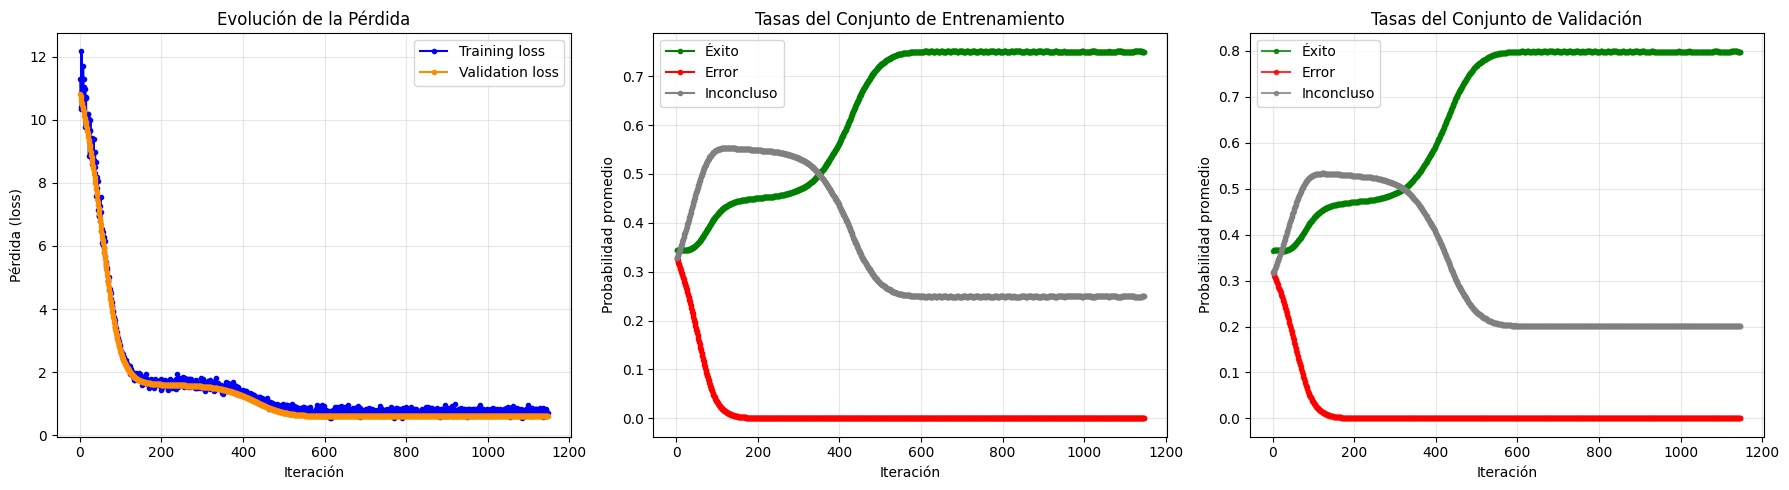

In [13]:
it = len(train_suc_history)

# Visualización de los resultados
plt.figure(figsize=(18, 5))

# 1. Evolución de la pérdida
plt.subplot(1, 3, 1)
plt.plot(range(1, it+1), loss_history, '.-', label="Training loss", color='blue')
plt.plot(range(1, it+1), val_loss_history, '.-', label="Validation loss", color='darkorange')
plt.xlabel("Iteración")
plt.ylabel("Pérdida (loss)")
plt.title("Evolución de la Pérdida")
plt.grid(True, alpha=0.3)
plt.legend()

# 2. Tasas en entrenamiento
plt.subplot(1, 3, 2)
plt.plot(range(1, it+1), train_suc_history, '.-', label="Éxito", color='green')
plt.plot(range(1, it+1), train_err_history, '.-', label="Error", color='red')
plt.plot(range(1, it+1), train_inc_history, '.-', label="Inconcluso", color='gray')
plt.xlabel("Iteración")
plt.ylabel("Probabilidad promedio")
plt.title("Tasas del Conjunto de Entrenamiento")
plt.grid(True, alpha=0.3)
plt.legend()

# 3. Tasas en validación
plt.subplot(1, 3, 3)
plt.plot(range(1, it+1), val_suc_history, '.-', label="Éxito", color='green', alpha=0.8)
plt.plot(range(1, it+1), val_err_history, '.-', label="Error", color='red', alpha=0.8)
plt.plot(range(1, it+1), val_inc_history, '.-', label="Inconcluso", color='gray', alpha=0.8)
plt.xlabel("Iteración")
plt.ylabel("Probabilidad promedio")
plt.title("Tasas del Conjunto de Validación")
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

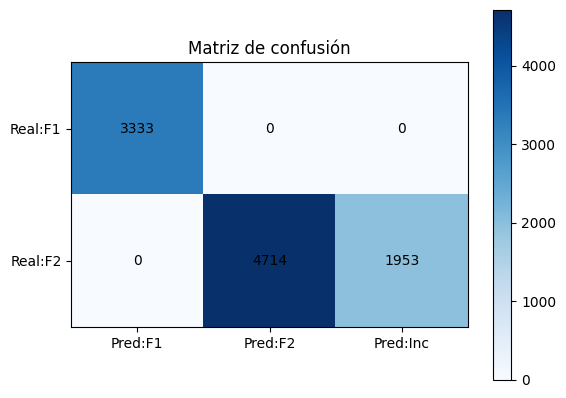

In [14]:
#Matriz de confusión

def predict_label(params, val, actual_label):
    """
    Devuelve la predicción discreta:
      1 => familia 1
      2 => familia 2
      3 => inconcluso


    actual_label se usa para saber qué outcome corresponde a éxito o error.
    """
    probs = get_probabilities(params, val, actual_label)

    p_fam1 = probs[0] + probs[2]
    p_fam2 = probs[1]
    p_inc  = probs[3]

    # Tomamos la mayor de las tres
    idx = np.argmax([p_fam1, p_fam2, p_inc])
    predicted = [1, 2, 3][idx]  # 1=fam1, 2=fam2, 3=inconcluso
    return predicted

def confusion_matrix_inconclusive(params, samples):

    cm = np.zeros((2, 3))
    for (val, actual_label) in samples:
        pred = predict_label(params, val, actual_label)
        row = actual_label - 1  # (1->0, 2->1)
        col = pred - 1          # (1->0, 2->1, 3->2)
        cm[row, col] += 1
    return cm

def plot_confusion_matrix_inconclusive(cm, normalize=False):
    """
    Dibuja la matriz
    """
    cm_display = cm.copy()
    if normalize:
        for i in range(cm_display.shape[0]):
            row_sum = np.sum(cm_display[i, :])
            if row_sum > 0:
                cm_display[i, :] /= row_sum


    fig, ax = plt.subplots()
    im = ax.imshow(cm_display, cmap='Blues', origin='upper')

    # Etiquetas de ejes
    ax.set_xticks([0,1,2])
    ax.set_yticks([0,1])
    ax.set_xticklabels(["Pred:F1","Pred:F2","Pred:Inc"])
    ax.set_yticklabels(["Real:F1","Real:F2"])

    # Texto en cada celda
    for i in range(2):
        for j in range(3):
            val = cm_display[i, j]
            if normalize:
                txt = f"{val*100:.1f}%"
            else:
                txt = f"{val:.0f}"
            ax.text(j, i, txt, ha='center', va='center', color='black')

    plt.colorbar(im, ax=ax)
    plt.title("Matriz de confusión")
    plt.show()


cm_test = confusion_matrix_inconclusive(params, data_test)
plot_confusion_matrix_inconclusive(cm_test, normalize=False)
